## Mod4 Project Submission
- Student name: Juliette Cabrera
- Student pace: Part-Time
- Scheduled project review date/time: Feburary 5, 2020/ 6:00pm
- Instructor name: Matt Sparr
- Blog post URL:

## The Question: 
- What are the top 5 best zipcodes for the real-estate investment firm to invest in the New York Metro Area?

## Steps taken to answer the question:
- Explored the given dataframe from Zillow and narrowed down the New York Metro area.
- Found the top 5 zipcodes in the New York Metro area that had the largest Return on Investment (ROI) from the given years. 
- Use the ARIMA model on a test period of 6 months to see if the predicted models matched the actual data given.
- Used the ARIMA model on the whole dataset to forecast ROI for 6 months, 1 year, 5 years, and 10 years.
- Interpert the findings.

# 1. Import all the necessary libraries, data set, and define functions that will be needed.
___

In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pyplot import rcParams
plt.style.use('fivethirtyeight')

import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def roi(current, previous):
    roi = ((current - previous)/previous)*100
    return round(roi,2)

df = pd.read_csv('zillow_data.csv')

In [2]:
# Note that the zipcodes in this dataset is referred to as 'RegionName'.
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# 2. Investigate the Data
___

#### The real-estate firm is looking to invest in the New York Metro area in the state of New Jersey, so the dataset needs to be filtered out to just find the information that pertains to New York Metro.
- First, make a new dataframe for all of New Jersey only.
- Second, from that NJ dataframe, filter out only the New York Metro area, this will be the dataframe to work from for now.

In [3]:
nj = df[df['State']=='NJ']
nj.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
57,60545,7030,Hoboken,NJ,New York,Hudson,58,301600.0,302700.0,303800.0,...,1789100,1803000,1818100,1836900,1850100,1853500,1852200,1854400,1857600,1854300
73,61148,8701,Lakewood,NJ,New York,Ocean,74,153800.0,153400.0,153000.0,...,400500,403900,408400,411000,412600,414000,415700,415600,413400,410700
158,61169,8753,Toms River,NJ,New York,Ocean,159,123400.0,123200.0,122900.0,...,258600,258700,259000,259500,261200,262500,262600,262400,263400,264300
187,60518,7002,Bayonne,NJ,New York,Hudson,188,145000.0,144500.0,143900.0,...,318500,324100,330900,339000,347400,352800,355900,361500,368700,372900
191,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0,137800.0,138500.0,...,1340200,1372300,1411000,1435900,1446300,1447800,1454900,1453900,1439500,1427300


In [4]:
nj_copy = nj.copy()

In [5]:
ny_metro = nj[nj['Metro']=='New York']
len(ny_metro)

361

#### The real-estate firm wants to be able to invest in an area that that has a yearly property value that falls between 25% and 75% of the median prices of all of the New York Metro area.
- Find the average price of the last year from the dataset and add a new column to the the dataframe.  
    - This can be done with .iloc[row, columns] and using the .mean() function
        - It is important to note to use axis=1 in the mean parameters, because we want to focus on the columns and not the index which is the default.
- Drop all the columns that are not needed, focusing only on the dates, the zipcode (RegionName) and the new column, yearly average price.
- Find the prices that fall between 25% and 75% of the median price by using .describe()
- Make a new dataframe that only has the zipcodes that fall within that range.

In [6]:
ny_metro['yearly average price'] = ny_metro.iloc[:, -12:].mean(axis=1) 
ny_metro.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,yearly average price
57,60545,7030,Hoboken,NJ,New York,Hudson,58,301600.0,302700.0,303800.0,...,1803000,1818100,1836900,1850100,1853500,1852200,1854400,1857600,1854300,1.821550e+06
73,61148,8701,Lakewood,NJ,New York,Ocean,74,153800.0,153400.0,153000.0,...,403900,408400,411000,412600,414000,415700,415600,413400,410700,4.086917e+05
158,61169,8753,Toms River,NJ,New York,Ocean,159,123400.0,123200.0,122900.0,...,258700,259000,259500,261200,262500,262600,262400,263400,264300,2.607583e+05
187,60518,7002,Bayonne,NJ,New York,Hudson,188,145000.0,144500.0,143900.0,...,324100,330900,339000,347400,352800,355900,361500,368700,372900,3.414250e+05
191,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0,137800.0,138500.0,...,1372300,1411000,1435900,1446300,1447800,1454900,1453900,1439500,1427300,1.404458e+06


In [7]:
nj_ny_metro = ny_metro.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)

In [8]:
display(nj_ny_metro['yearly average price'].describe())
print(len(nj_ny_metro))

count    3.610000e+02
mean     4.420354e+05
std      2.669593e+05
min      1.447917e+05
25%      2.799083e+05
50%      3.792917e+05
75%      5.322667e+05
max      3.013675e+06
Name: yearly average price, dtype: float64

361


In [9]:
avg_ny_metro = nj_ny_metro[(nj_ny_metro['yearly average price']>281519.4)&
                      (nj_ny_metro['yearly average price']<532697.2)]
len(avg_ny_metro)

179

#### The real-estate firm wants to focus solely on the zipcodes that have shown the most return on investment from 1996 to the current year of 2018.
- How to calculate ROI: roi = (current listing - previous listing)/previous listing
    - https://www.investopedia.com/terms/r/returnoninvestment.asp
- Note that the in order to see the percent, multiply the ROI given by 100.
- Add the Return on Investment column to the existing dataframe and sort the values where the highest ROI's are at the top of the dataframe.
    - source: https://pandas.pydata.org/pandasdocs/stable/reference/api/pandas.DataFrame.sort_values.html
- Make a new dataframe with the top 5 zipcodes with the highest ROI.
    - How to just have the top 5 zipcodes filtered from the original data source:
    - https://www.ritchieng.com/pandas-multi-criteria-filtering/

In [10]:
avg_ny_metro['ROI'] = ((avg_ny_metro['2018-04']-avg_ny_metro['1996-04'])/avg_ny_metro['1996-04'])

In [11]:
avg_ny_metro.head()

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,yearly average price,ROI
73,8701,153800.0,153400.0,153000.0,152500.0,152200.0,151900.0,151700.0,151700.0,151900.0,...,408400,411000,412600,414000,415700,415600,413400,410700,408691.666667,1.670351
187,7002,145000.0,144500.0,143900.0,143300.0,142800.0,142400.0,142100.0,142000.0,142100.0,...,330900,339000,347400,352800,355900,361500,368700,372900,341425.000000,1.571724
214,7093,131700.0,131900.0,132100.0,132300.0,132500.0,132700.0,133000.0,133500.0,134200.0,...,376800,386200,392900,395100,395500,399400,407000,412700,383350.000000,2.133637
278,8831,218500.0,217900.0,217100.0,216100.0,215200.0,214400.0,213900.0,213600.0,213800.0,...,433800,432100,432100,433000,434300,436000,436900,436500,434083.333333,0.997712
319,7087,127300.0,127000.0,126700.0,126400.0,126100.0,125900.0,125800.0,125800.0,126000.0,...,386000,394700,403700,410500,415500,424000,437400,448900,398000.000000,2.526316


In [110]:
avg_ny_metro_sorted = avg_ny_metro.sort_values(by=['ROI'], ascending=False) 

In [13]:
top_5_zips = avg_ny_metro_sorted[['RegionName', 'ROI']].head(5)
top_5_zips

,RegionName,ROI
9758,7756,4.418274
660,7306,3.896768
1737,7307,3.782152
319,7087,2.526316
4359,7719,2.252316


In [14]:
top_5 = ['7756', '7306', '7307', '7087', '7719']
nj_ny_zips = nj[nj.RegionName.isin(top_5)]

In [15]:
nj_ny_zips

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
319,60594,7087,Union City,NJ,New York,Hudson,320,127300.0,127000.0,126700.0,...,367000,377500,386000,394700,403700,410500,415500,424000,437400,448900
660,60643,7306,Jersey City,NJ,New York,Hudson,661,111400.0,111100.0,110900.0,...,465400,469800,475900,484000,495800,506700,510000,515300,531900,545500
1737,60644,7307,Jersey City,NJ,New York,Hudson,1738,114300.0,114300.0,114400.0,...,439500,449000,458300,468100,478200,487300,496000,510600,531900,546600
4359,60768,7719,Wall,NJ,New York,Monmouth,4360,140300.0,140300.0,140200.0,...,436600,437700,438300,438400,439700,444100,448900,452300,454700,456300
9758,60796,7756,Neptune,NJ,New York,Monmouth,9759,98500.0,99100.0,99600.0,...,498200,505000,510500,515800,521300,524200,528100,533300,535100,533700


# 3. Preparing Data for ARIMA
___

#### Get the dataset ready to run ARIMA.
- The dates need be made into rows instead of columns.
    - source: https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html
- Need to get the dataset ready for ARIMA modeling.

In [16]:
nj_ny_top = pd.melt(nj_ny_zips, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 
                                      'CountyName', 'SizeRank'], var_name='Date')
nj_ny_top['Date'] = pd.to_datetime(nj_ny_top['Date'], infer_datetime_format=True)
nj_ny_top = nj_ny_top.dropna(subset=['value'])

In [17]:
display(nj_ny_top.head())
display(nj_ny_top.tail())

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,value
0,60594,7087,Union City,NJ,New York,Hudson,320,1996-04-01,127300.0
1,60643,7306,Jersey City,NJ,New York,Hudson,661,1996-04-01,111400.0
2,60644,7307,Jersey City,NJ,New York,Hudson,1738,1996-04-01,114300.0
3,60768,7719,Wall,NJ,New York,Monmouth,4360,1996-04-01,140300.0
4,60796,7756,Neptune,NJ,New York,Monmouth,9759,1996-04-01,98500.0


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,value
1320,60594,7087,Union City,NJ,New York,Hudson,320,2018-04-01,448900.0
1321,60643,7306,Jersey City,NJ,New York,Hudson,661,2018-04-01,545500.0
1322,60644,7307,Jersey City,NJ,New York,Hudson,1738,2018-04-01,546600.0
1323,60768,7719,Wall,NJ,New York,Monmouth,4360,2018-04-01,456300.0
1324,60796,7756,Neptune,NJ,New York,Monmouth,9759,2018-04-01,533700.0


In [18]:
nj_ny_top.index = pd.DatetimeIndex(nj_ny_top.Date)

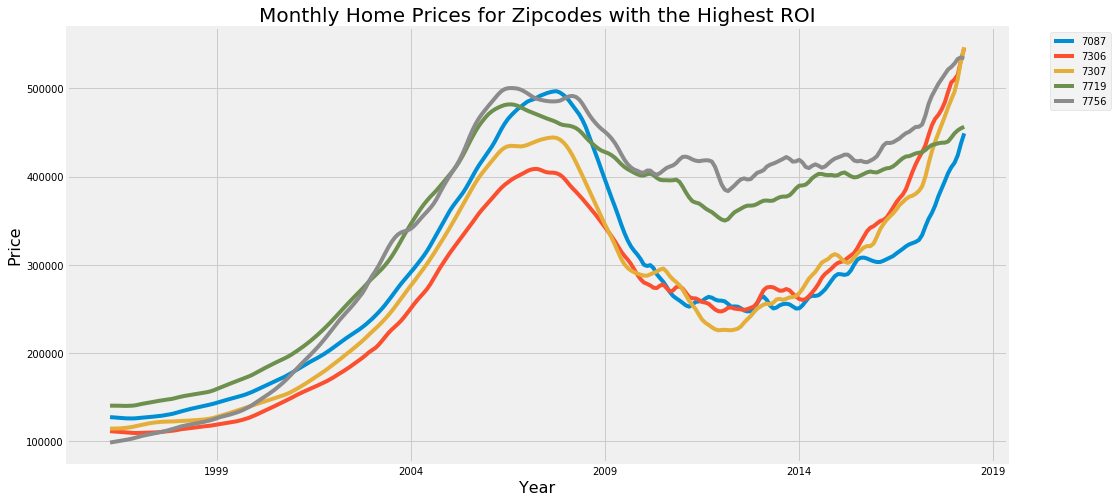

In [19]:
plt.figure(figsize=(14,6))
for zipcode in nj_ny_top.RegionName.unique():
    nj = nj_ny_top[nj_ny_top.RegionName == zipcode]
    nj['value'].plot(figsize=(15,8), label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel("Year", fontsize=16)
plt.ylabel("Price", fontsize=16)
plt.title("Monthly Home Prices for Zipcodes with the Highest ROI", fontsize=20);

# 4. Training ARIMA - 6 month test period
___

#### In order to make sure that the ARIMA model that is followed is accurate, must first train the model on a test period to make sure that perdictions that will be made are accurate.
- Source: https://github.com/lraichik/Predicting-average-real-estate-prices-by-zipcode/blob/master/Chicago.ipynb for the for loop used to find AIC params

In [20]:
p = d = q = range(0,2)
from itertools import product
pdq = list(itertools.product(p,d,q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

In [21]:
test_period = 6
aic_params = []
for zipcode in nj_ny_top.RegionName.unique():
    ans = []
    for param in pdq:
        for param_seasonal in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(nj_ny_top.loc[nj_ny_top['RegionName'] == zipcode][:-test_period].value,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results_top = mod.fit()
                ans.append([zipcode, param, param_seasonal, results_top.aic])
            except:
                continue
    aic_params.append(sorted(ans, key=lambda x: x[3])[0])

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/lea

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/lea

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/lea

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/lea

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/lea

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/lea

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/lea

#### Parameters for the ARIMA model.

In [22]:
aic_params

[[7087, (1, 1, 1), (1, 1, 1, 12), 4038.3986490229304],
 [7306, (1, 1, 1), (1, 1, 1, 12), 3964.26201011944],
 [7307, (1, 1, 1), (1, 1, 1, 12), 3937.0612933354814],
 [7719, (1, 1, 1), (1, 1, 1, 12), 3837.3690309199064],
 [7756, (1, 1, 1), (1, 1, 1, 12), 4059.4014527964214]]

#### Save the models for top zipcodes to the models list.

In [23]:
models = []
for i in aic_params:
    df_ = nj_ny_top.loc[nj_ny_top['RegionName'] == i[0]][:-test_period].value.dropna()
    mod = sm.tsa.statespace.SARIMAX(df_,
                            order=i[1],
                            seasonal_order=i[2],
                            enforce_stationarity=False,
                            enforce_invertibility=False,)

    top_results = mod.fit()
    models.append(top_results)
    print(i[0], '\n' , top_results.summary().tables[1])

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


7087 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8403      0.038     21.944      0.000       0.765       0.915
ma.L1          0.6582      0.045     14.468      0.000       0.569       0.747
ar.S.L12       0.2003      0.062      3.233      0.001       0.079       0.322
ma.S.L12      -0.5518      0.048    -11.556      0.000      -0.645      -0.458
sigma2      2.152e+06   1.55e+05     13.914      0.000    1.85e+06    2.46e+06


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


7306 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7744      0.044     17.472      0.000       0.688       0.861
ma.L1          0.7855      0.043     18.233      0.000       0.701       0.870
ar.S.L12       0.1294      0.049      2.654      0.008       0.034       0.225
ma.S.L12      -0.4893      0.039    -12.453      0.000      -0.566      -0.412
sigma2      1.738e+06   1.56e+05     11.155      0.000    1.43e+06    2.04e+06


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


7307 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9416      0.019     49.206      0.000       0.904       0.979
ma.L1          0.3372      0.014     24.890      0.000       0.311       0.364
ar.S.L12      -0.7331      0.033    -22.304      0.000      -0.798      -0.669
ma.S.L12      -0.0350      0.024     -1.433      0.152      -0.083       0.013
sigma2      1.245e+06   7.88e+04     15.791      0.000    1.09e+06     1.4e+06


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


7719 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8424      0.047     17.841      0.000       0.750       0.935
ma.L1          0.5856      0.052     11.262      0.000       0.484       0.688
ar.S.L12       0.1615      0.099      1.624      0.104      -0.033       0.356
ma.S.L12      -0.5859      0.079     -7.405      0.000      -0.741      -0.431
sigma2      9.459e+05   8.22e+04     11.512      0.000    7.85e+05    1.11e+06


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


7756 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7622      0.037     20.510      0.000       0.689       0.835
ma.L1          0.7808      0.026     30.013      0.000       0.730       0.832
ar.S.L12       0.1442      0.043      3.359      0.001       0.060       0.228
ma.S.L12      -0.6302      0.028    -22.851      0.000      -0.684      -0.576
sigma2      1.858e+06   1.14e+05     16.273      0.000    1.63e+06    2.08e+06


In [24]:
predictions = []
for i in models:
    prediction_nj = i.forecast(steps=test_period)
    predictions.append(prediction_nj)

#### Compare the predicted values versus the true values to see how well the model works.
- Using Root Mean Square Error to help determine the difference between true versus predicted.

MAE: 3087.9262734122362


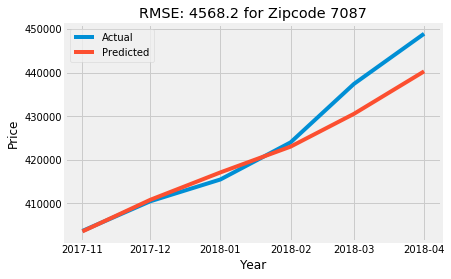

MAE: 9402.735036601041


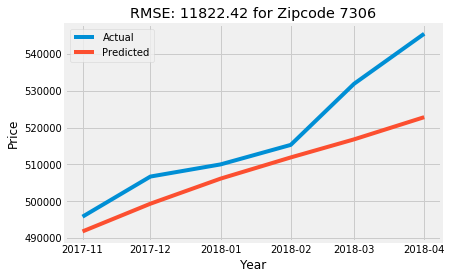

MAE: 4233.161989300269


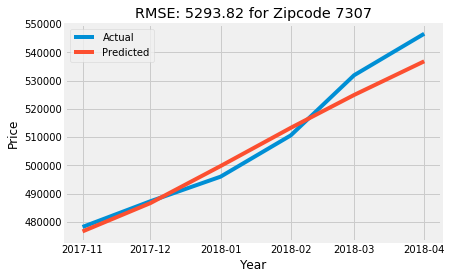

MAE: 10840.877137435338


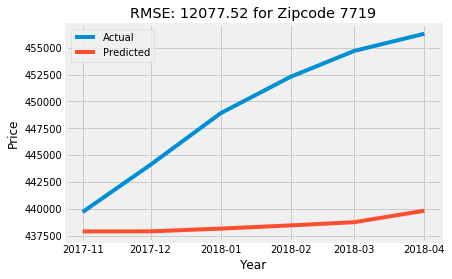

MAE: 2873.4109047486177


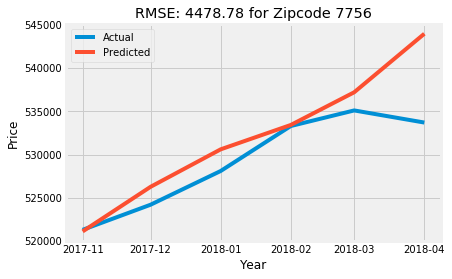

In [25]:
for i,j in zip(predictions,nj_ny_top.RegionName.unique()):
    plt.plot(nj_ny_top[nj_ny_top.RegionName==j].value[-test_period:])
    plt.plot(i)
    plt.xlabel("Year")
    plt.ylabel("Price")
    plt.title('RMSE: ' + str(round(np.sqrt(mean_squared_error(nj_ny_top[nj_ny_top.RegionName==j].value[-test_period:], i)),2)) + ' for Zipcode ' +  str(j)) 
    plt.legend(['Actual', 'Predicted'])
    print('MAE:', mean_absolute_error(nj_ny_top[nj_ny_top.RegionName==j].value[-test_period:], i))
    plt.show()

#### The models look good, close to the true values, the parameters found can be used on the whole data to be able to forecast.

# 5. Final Model
___

In [26]:
final_models = []
for i in aic_params:
    df_ = nj_ny_top.loc[nj_ny_top['RegionName'] == i[0]].value.dropna()
    mod = sm.tsa.statespace.SARIMAX(df_,
                            order=i[1],
                            seasonal_order=i[2],
                            enforce_stationarity=False,
                            enforce_invertibility=False,)

    top_results_final = mod.fit()
    final_models.append(top_results_final)
    print(i[0], '\n' , top_results_final.summary().tables[1])

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


7087 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8282      0.037     22.542      0.000       0.756       0.900
ma.L1          0.6684      0.045     14.945      0.000       0.581       0.756
ar.S.L12       0.1974      0.061      3.211      0.001       0.077       0.318
ma.S.L12      -0.5389      0.047    -11.359      0.000      -0.632      -0.446
sigma2      2.265e+06   1.63e+05     13.917      0.000    1.95e+06    2.58e+06


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


7306 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6621      0.037     17.930      0.000       0.590       0.734
ma.L1          0.7904      0.035     22.700      0.000       0.722       0.859
ar.S.L12       0.1386      0.068      2.034      0.042       0.005       0.272
ma.S.L12      -0.4127      0.062     -6.681      0.000      -0.534      -0.292
sigma2       2.46e+06   1.34e+05     18.333      0.000     2.2e+06    2.72e+06


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


7307 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9100      0.029     31.348      0.000       0.853       0.967
ma.L1          0.3009      0.025     12.228      0.000       0.253       0.349
ar.S.L12      -0.7089      0.055    -12.819      0.000      -0.817      -0.601
ma.S.L12      -0.0251      0.044     -0.571      0.568      -0.111       0.061
sigma2      2.699e+06   1.61e+05     16.727      0.000    2.38e+06    3.02e+06


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


7719 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8359      0.048     17.596      0.000       0.743       0.929
ma.L1          0.5969      0.051     11.718      0.000       0.497       0.697
ar.S.L12       0.1590      0.098      1.623      0.105      -0.033       0.351
ma.S.L12      -0.5789      0.077     -7.494      0.000      -0.730      -0.428
sigma2      9.597e+05   8.28e+04     11.594      0.000    7.97e+05    1.12e+06


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


7756 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7875      0.048     16.431      0.000       0.694       0.881
ma.L1          0.4801      0.031     15.488      0.000       0.419       0.541
ar.S.L12      -0.4304      0.069     -6.282      0.000      -0.565      -0.296
ma.S.L12      -0.1365      0.037     -3.729      0.000      -0.208      -0.065
sigma2      3.358e+06   2.51e+05     13.377      0.000    2.87e+06    3.85e+06


7087


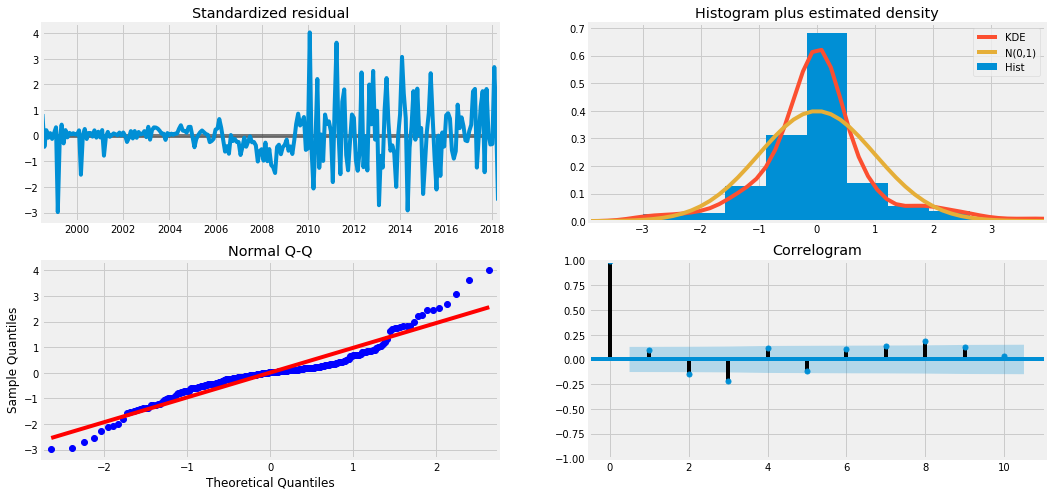

7306


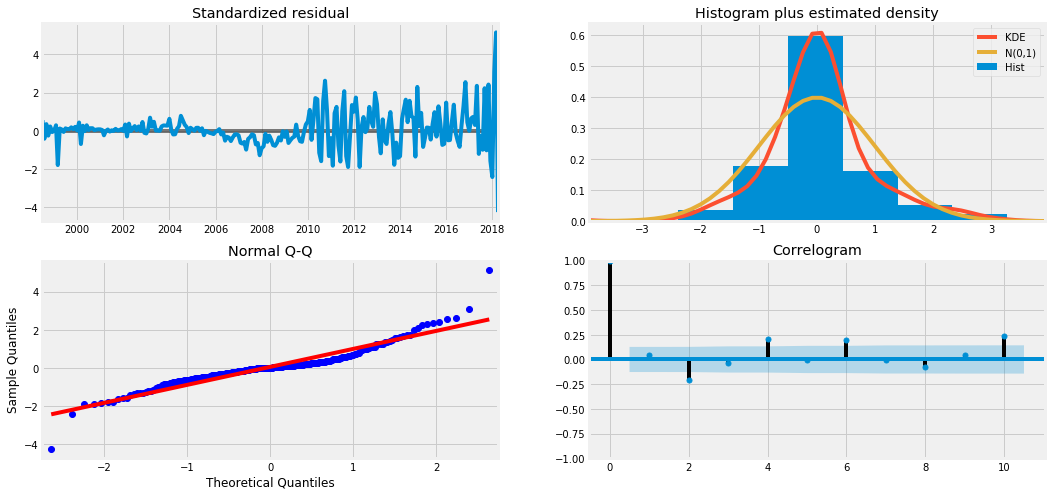

7307


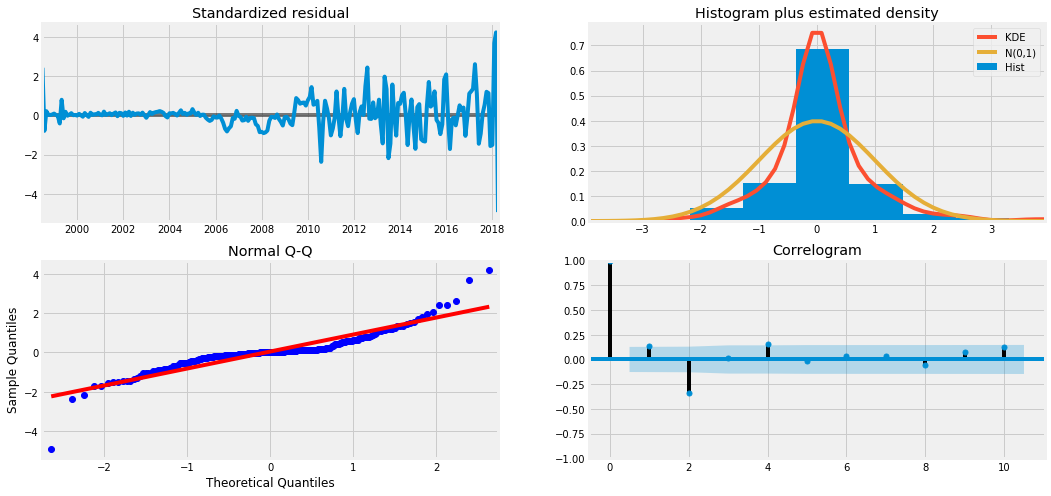

7719


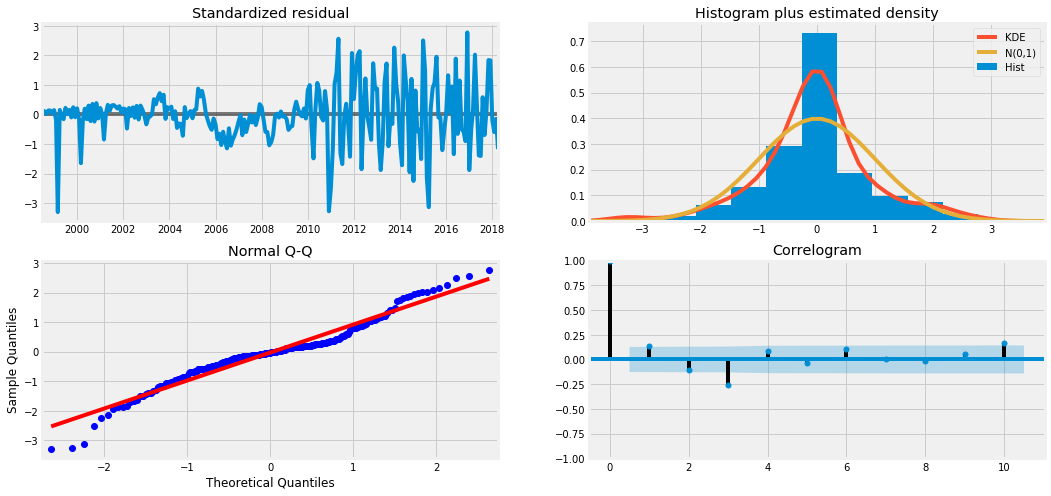

7756


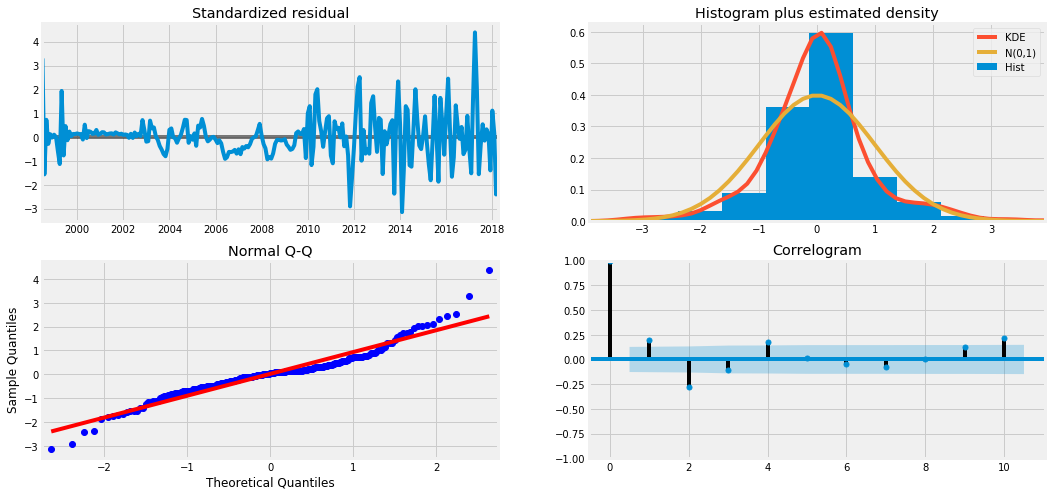

In [27]:
for i, zipcode in zip(final_models, aic_params):
    print(zipcode[0])
    i.plot_diagnostics(figsize=(16,8))
    plt.show()

# 6. Forecast
___
## 6 months

In [28]:
forecast_6mon = []
intervals_6mon = []
for i in final_models:
    prediction_nj_ny6 = i.get_forecast(steps=6)
    pred_conf_nj_ny6 = prediction_nj_ny6.conf_int()
    forecast_6mon.append(prediction_nj_ny6)
    intervals_6mon.append(pred_conf_nj_ny6)

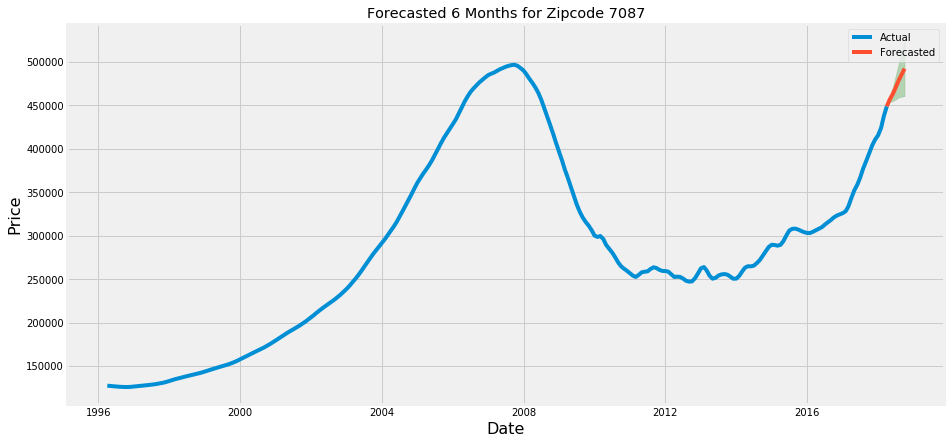

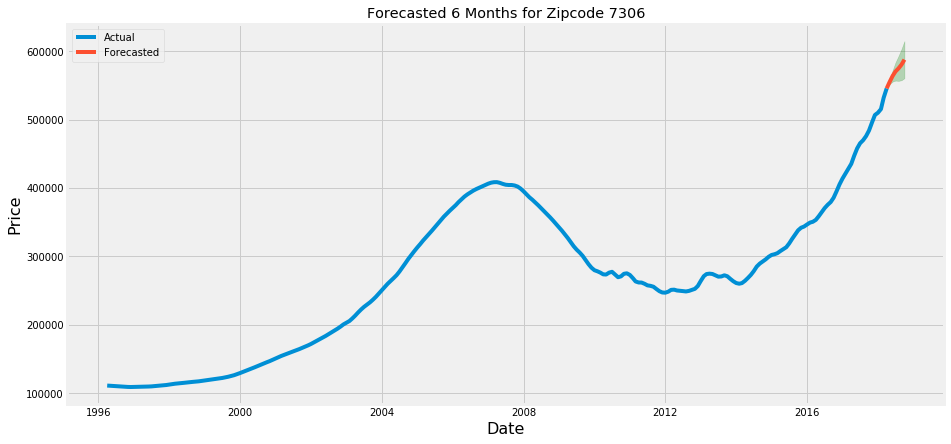

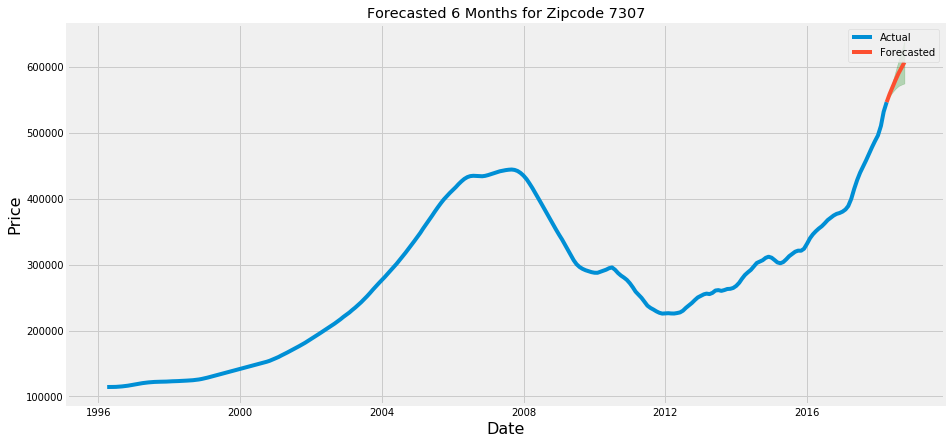

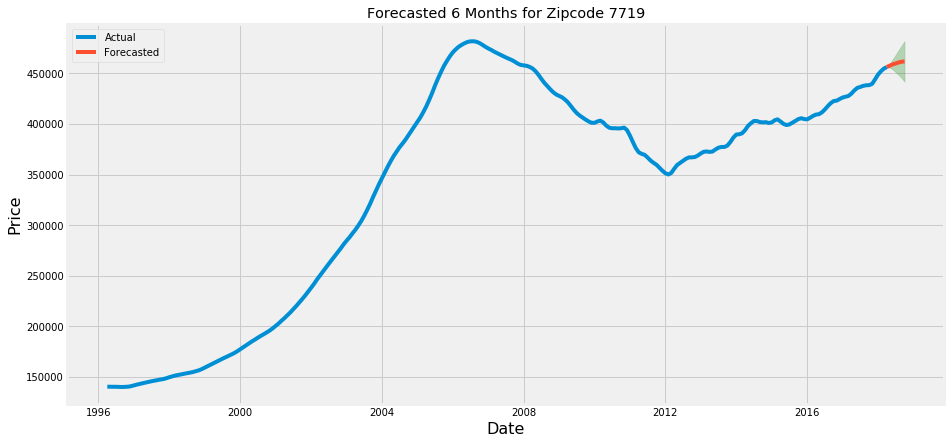

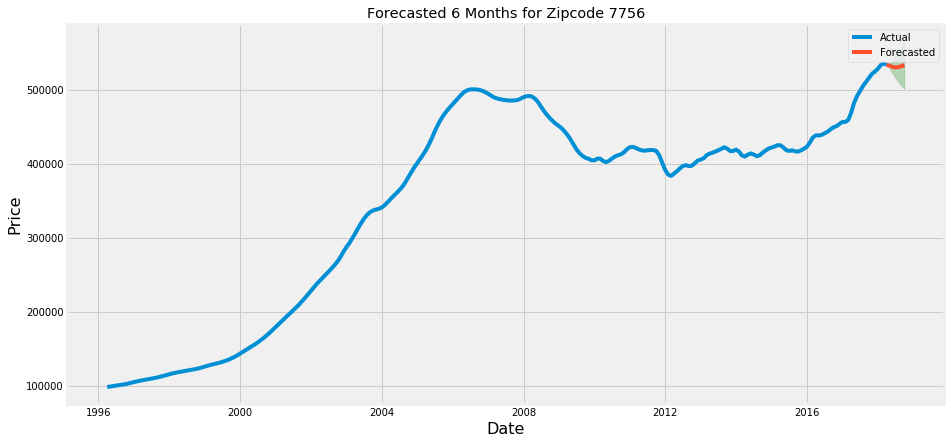

In [181]:
for i,j,k in zip(forecast_6mon,intervals_6mon,nj_ny_top.RegionName.unique()):
    plt.figure(figsize=(14,7))
    forecast_ = list(i.predicted_mean.values) # a list of the forecasted values
    index_ = list(forecast_6mon[0].predicted_mean.index) # a list of the index of the forecasted values
    forecast_.insert(0, list(nj_ny_top[nj_ny_top.RegionName==k].value)[-1]) # adding the last value of the true data
    index_.insert(0, list(nj_ny_top[nj_ny_top.RegionName==k].index)[-1]) # adding the last index of the true data
    plt.plot(nj_ny_top[nj_ny_top.RegionName==k].value)
    plt.plot(index_, forecast_)
    plt.fill_between(j.index,
                   j.iloc[:, 0],
                   j.iloc[:, 1], color = 'g', alpha=.25)
    plt.legend(['Actual', 'Forecasted'])
    plt.xlabel("Year", fontsize=16)
    plt.ylabel("Price", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title('Forecasted 6 Months for Zipcode ' + str(k))
    plt.show()

## 1 year

In [30]:
forecast_1y = []
intervals_1y = []
for i in final_models:
    prediction_nj_ny1 = i.get_forecast(steps=12)
    pred_conf_nj_ny1 = prediction_nj_ny1.conf_int()
    forecast_1y.append(prediction_nj_ny1)
    intervals_1y.append(pred_conf_nj_ny1)

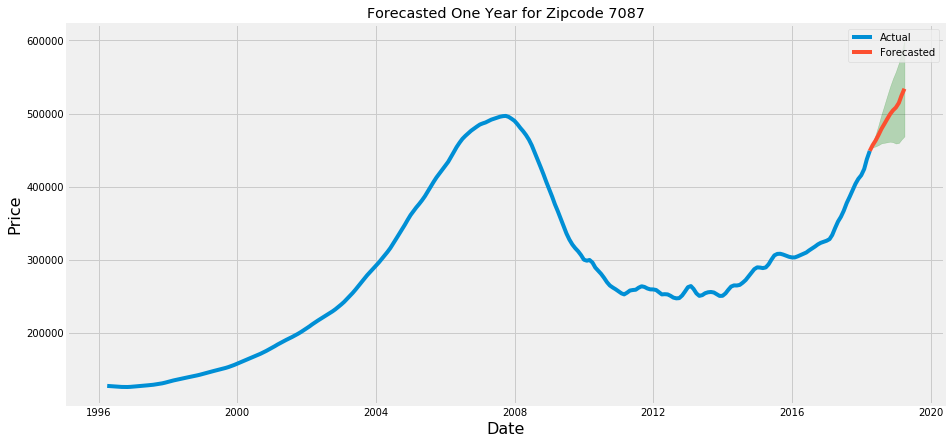

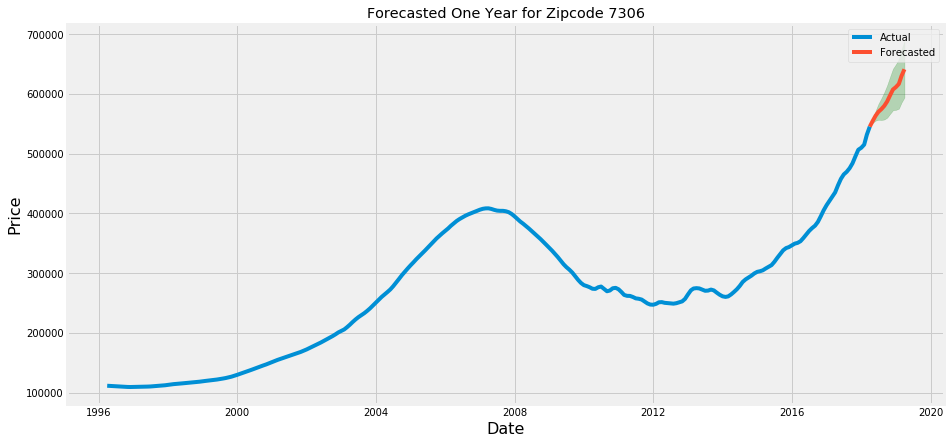

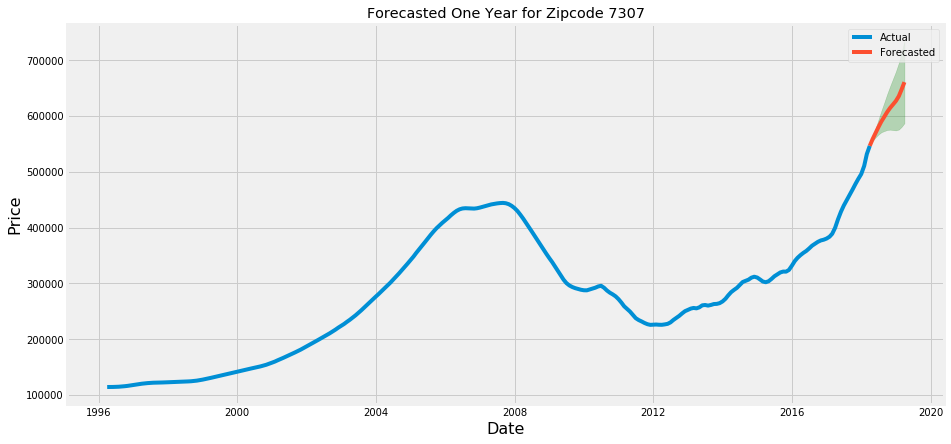

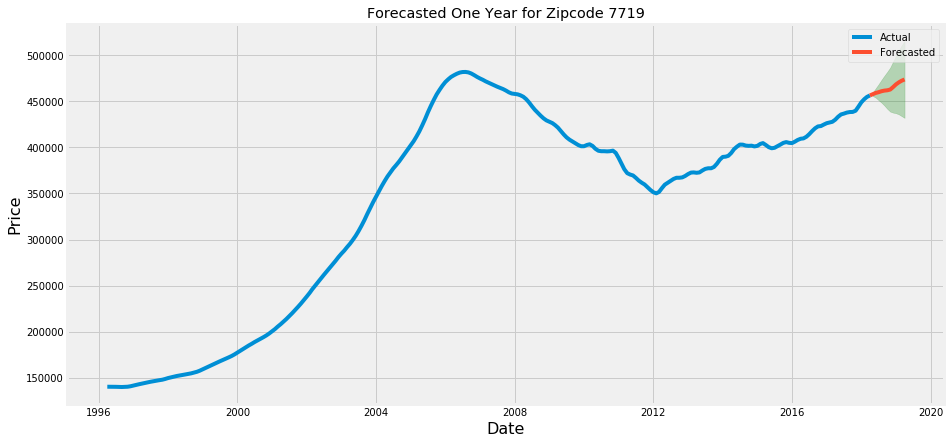

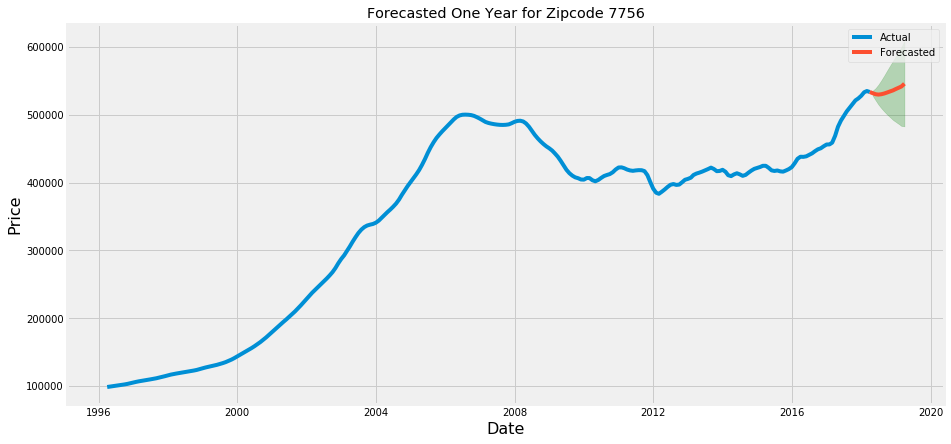

In [179]:
for i,j,k in zip(forecast_1y,intervals_1y,nj_ny_top.RegionName.unique()):
    plt.figure(figsize=(14,7))
    forecast_ = list(i.predicted_mean.values) # a list of the forecasted values
    index_ = list(forecast_1y[0].predicted_mean.index) # a list of the index of the forecasted values
    forecast_.insert(0, list(nj_ny_top[nj_ny_top.RegionName==k].value)[-1]) # adding the last value of the true data
    index_.insert(0, list(nj_ny_top[nj_ny_top.RegionName==k].index)[-1]) # adding the last index of the true data
    plt.plot(nj_ny_top[nj_ny_top.RegionName==k].value)
    plt.plot(index_, forecast_)
    plt.fill_between(j.index,
                   j.iloc[:, 0],
                   j.iloc[:, 1], color = 'g', alpha=.25)
    plt.legend(['Actual', 'Forecasted'])
    plt.xlabel("Year", fontsize=16)
    plt.ylabel("Price", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title('Forecasted One Year for Zipcode ' + str(k))
    plt.show()

## 5 years

In [32]:
forecast_5y = []
intervals_5y = []
for i in final_models:
    prediction_nj_ny5 = i.get_forecast(steps=60)
    pred_conf_nj_ny5 = prediction_nj_ny5.conf_int()
    forecast_5y.append(prediction_nj_ny5)
    intervals_5y.append(pred_conf_nj_ny5)

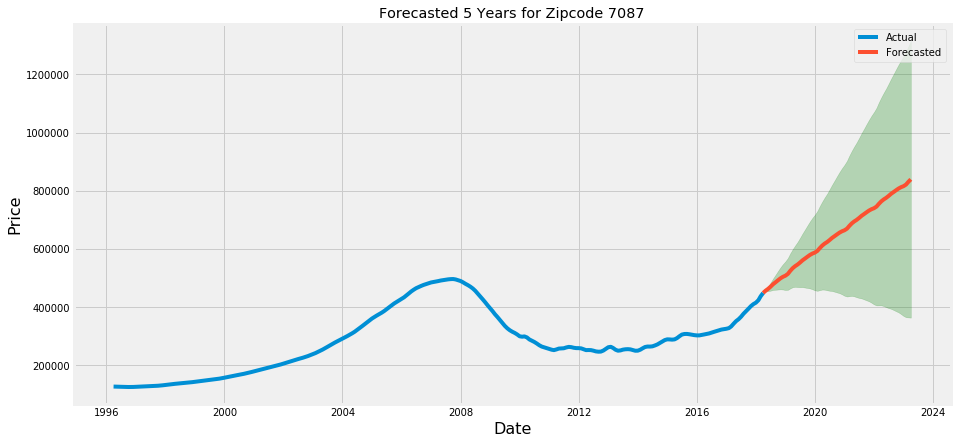

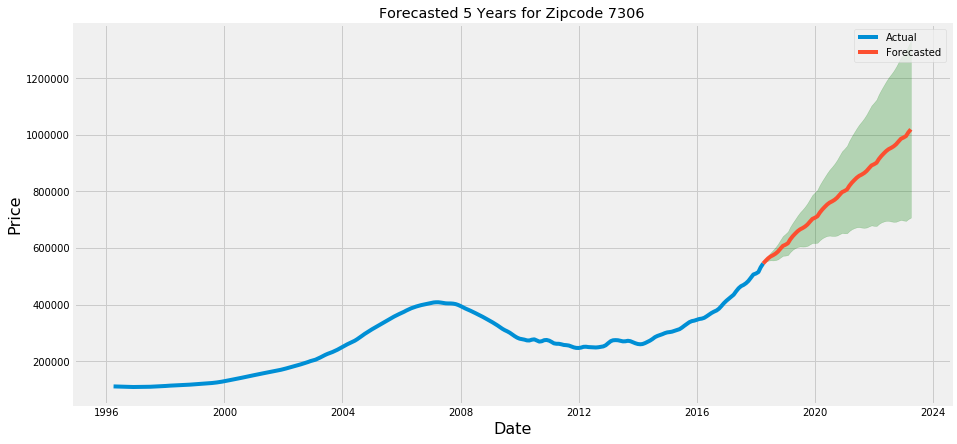

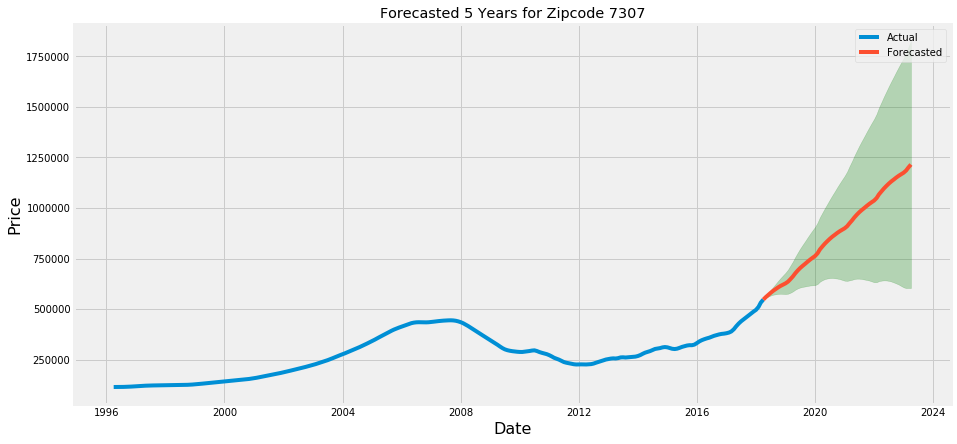

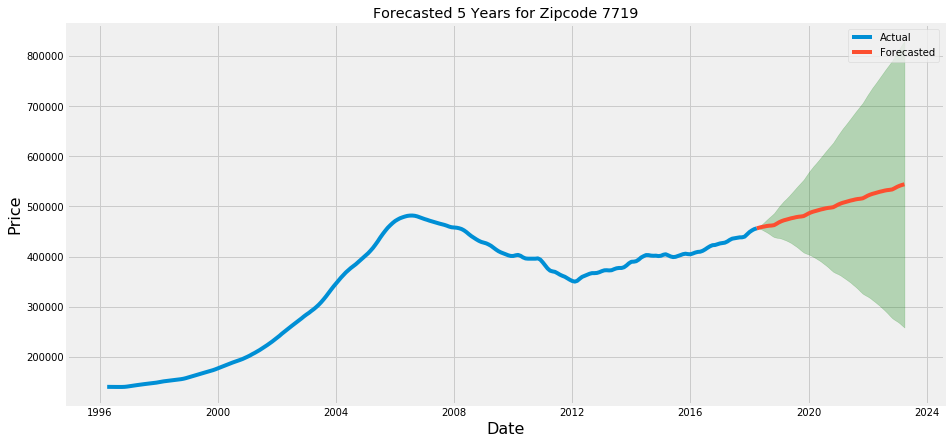

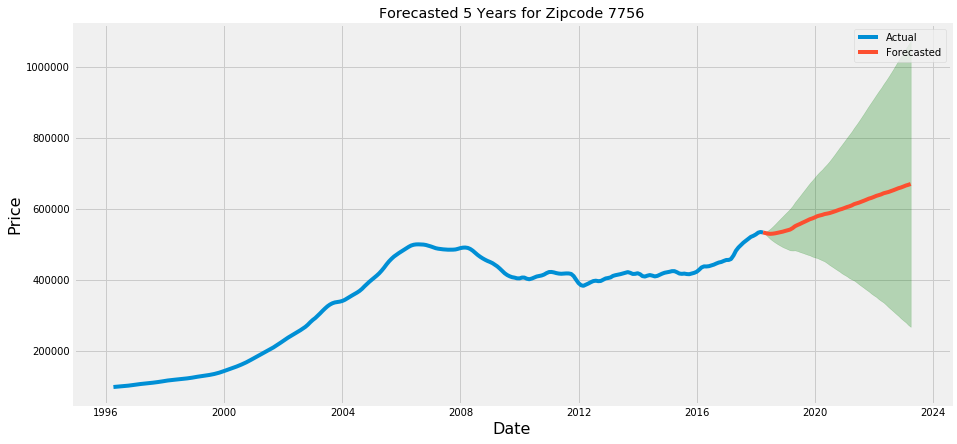

In [185]:
for i,j,k in zip(forecast_5y,intervals_5y,nj_ny_top.RegionName.unique()):
    plt.figure(figsize=(14,7))
    forecast_ = list(i.predicted_mean.values) # a list of the forecasted values
    index_ = list(forecast_5y[0].predicted_mean.index) # a list of the index of the forecasted values
    forecast_.insert(0, list(nj_ny_top[nj_ny_top.RegionName==k].value)[-1]) # adding the last value of the true data
    index_.insert(0, list(nj_ny_top[nj_ny_top.RegionName==k].index)[-1]) # adding the last index of the true data
    plt.plot(nj_ny_top[nj_ny_top.RegionName==k].value)
    plt.plot(index_, forecast_)
    plt.fill_between(j.index,
                   j.iloc[:, 0],
                   j.iloc[:, 1], color = 'g', alpha=.25)
    plt.legend(['Actual', 'Forecasted'])
    plt.xlabel("Year", fontsize=16)
    plt.ylabel("Price", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title('Forecasted 5 Years for Zipcode ' + str(k))
    plt.show()

## 10 years

In [34]:
forecast_10y = []
intervals_10y = []
for i in final_models:
    prediction_nj_ny10 = i.get_forecast(steps=120)
    pred_conf_nj_ny10 = prediction_nj_ny10.conf_int()
    forecast_10y.append(prediction_nj_ny10)
    intervals_10y.append(pred_conf_nj_ny10)

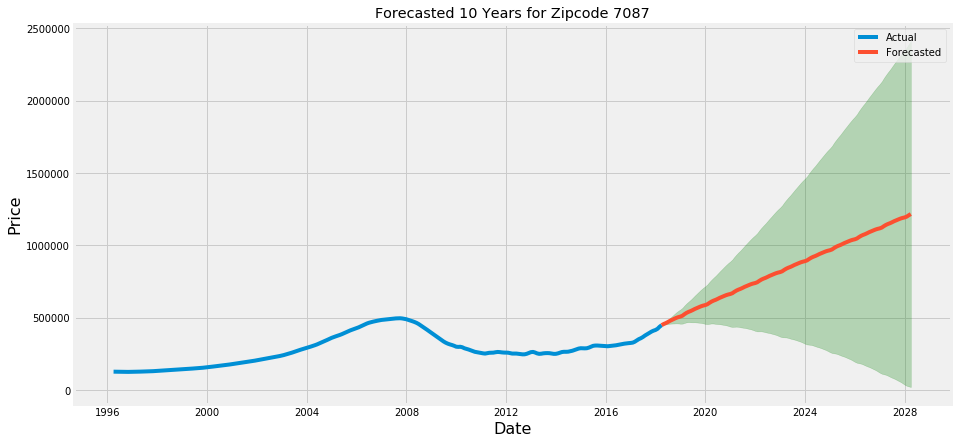

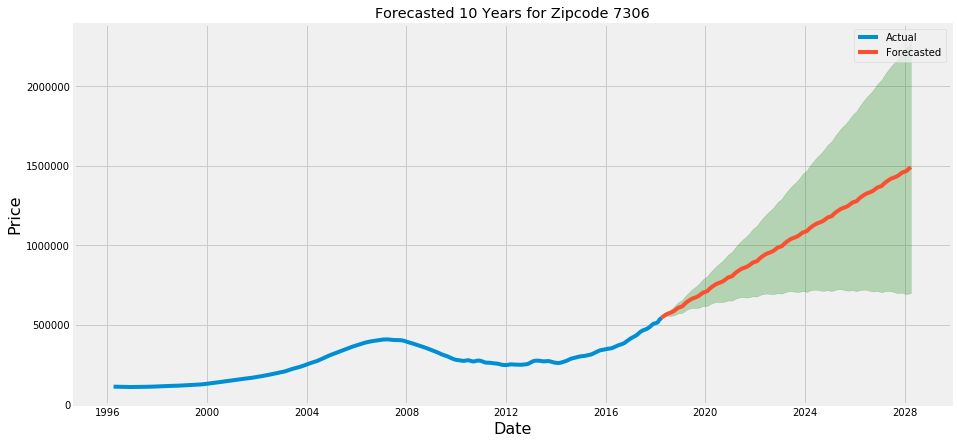

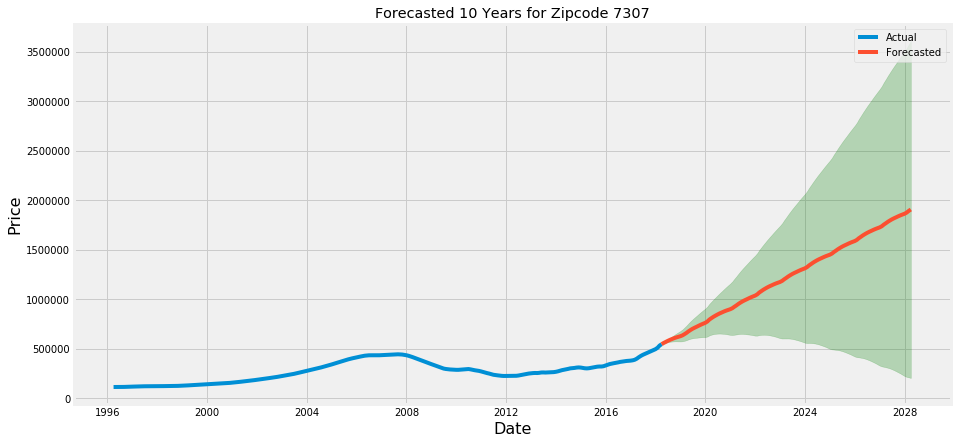

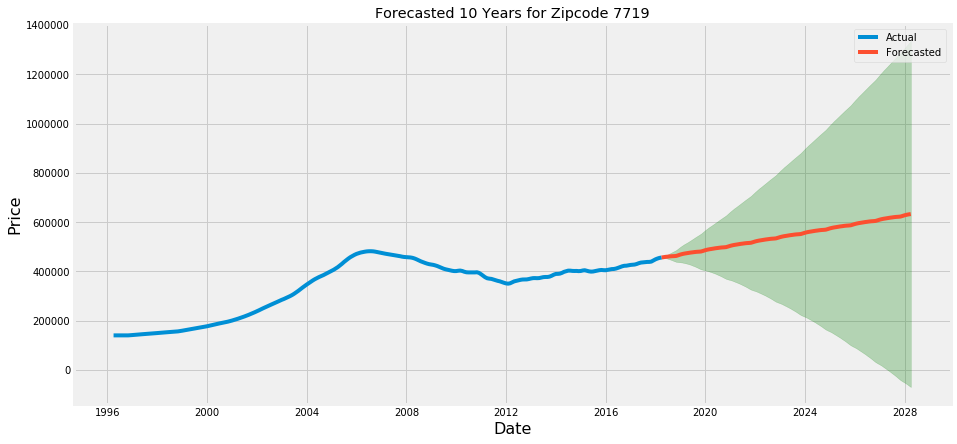

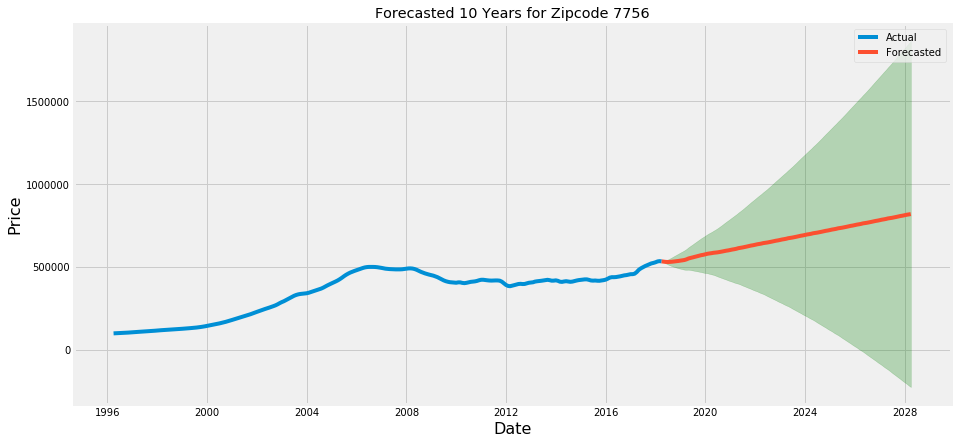

In [186]:
for i,j,k in zip(forecast_10y,intervals_10y,nj_ny_top.RegionName.unique()):
    plt.figure(figsize=(14,7))
    forecast_ = list(i.predicted_mean.values) # a list of the forecasted values
    index_ = list(forecast_10y[0].predicted_mean.index) # a list of the index of the forecasted values
    forecast_.insert(0, list(nj_ny_top[nj_ny_top.RegionName==k].value)[-1]) # adding the last value of the true data
    index_.insert(0, list(nj_ny_top[nj_ny_top.RegionName==k].index)[-1]) # adding the last index of the true data
    plt.plot(nj_ny_top[nj_ny_top.RegionName==k].value)
    plt.plot(index_, forecast_)
    plt.fill_between(j.index,
                   j.iloc[:, 0],
                   j.iloc[:, 1], color = 'g', alpha=.25)
    plt.legend(['Actual', 'Forecasted'])
    plt.xlabel("Year", fontsize=16)
    plt.ylabel("Price", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title('Forecasted 10 Years for Zipcode ' + str(k))
    plt.show()

#### Save the values found for the forecast in order to make a new dataframe for the expected ROI's for each forecasted value.

In [36]:
forecasted_values_6mons = []
forecasted_values_1yr = []
forecasted_values_5yrs = []
forecasted_values_10yrs = []
for i,j,k,l in zip(forecast_6mon, forecast_1y, forecast_5y, forecast_10y):
    values6 = i.predicted_mean
    values1 = j.predicted_mean
    values5 = k.predicted_mean
    values10 = l.predicted_mean
    forecasted_values_6mons.append(values6)
    forecasted_values_1yr.append(values1)
    forecasted_values_5yrs.append(values5)
    forecasted_values_10yrs.append(values10)

#### Predicted values for six months for each zipcode and their ROI.

In [37]:
six_07087 = pd.DataFrame(forecasted_values_6mons[0], columns=['6mon'])
six_07306 = pd.DataFrame(forecasted_values_6mons[1], columns=['6mon'])
six_07307 = pd.DataFrame(forecasted_values_6mons[2], columns=['6mon'])
six_07719 = pd.DataFrame(forecasted_values_6mons[3], columns=['6mon'])
six_07756 = pd.DataFrame(forecasted_values_6mons[4], columns=['6mon'])

In [38]:
six_months = pd.concat([six_07087, six_07306, six_07307, six_07719, six_07756], axis=1)
six_months.columns = ['07087', '07306', '07307', '07719', '07756']

In [39]:
print('07087:', roi(six_months['07087'][-1], nj_ny_top[nj_ny_top['RegionName']==7087].value[-1]))
print('07306:', roi(six_months['07306'][-1], nj_ny_top[nj_ny_top['RegionName']==7306].value[-1]))
print('07307:', roi(six_months['07307'][-1], nj_ny_top[nj_ny_top['RegionName']==7307].value[-1]))
print('07719:', roi(six_months['07719'][-1], nj_ny_top[nj_ny_top['RegionName']==7719].value[-1]))
print('07756:', roi(six_months['07756'][-1], nj_ny_top[nj_ny_top['RegionName']==7756].value[-1]))

07087: 9.67
07306: 7.71
07307: 11.07
07719: 1.22
07756: -0.14


#### Predictied values for 1 year for each zipcode and their ROI.

In [40]:
one_07087 = pd.DataFrame(forecasted_values_1yr[0], columns=['1year'])
one_07306 = pd.DataFrame(forecasted_values_1yr[1], columns=['1year'])
one_07307 = pd.DataFrame(forecasted_values_1yr[2], columns=['1year'])
one_07719 = pd.DataFrame(forecasted_values_1yr[3], columns=['1year'])
one_07756 = pd.DataFrame(forecasted_values_1yr[4], columns=['1year'])

In [41]:
one_year = pd.concat([one_07087, one_07306, one_07307, one_07719, one_07756], axis=1)
one_year.columns = ['07087', '07306', '07307', '07719', '07756']

In [42]:
print('07087:', roi(one_year['07087'][-1], nj_ny_top[nj_ny_top['RegionName']==7087].value[-1]))
print('07306:', roi(one_year['07306'][-1], nj_ny_top[nj_ny_top['RegionName']==7306].value[-1]))
print('07307:', roi(one_year['07307'][-1], nj_ny_top[nj_ny_top['RegionName']==7307].value[-1]))
print('07719:', roi(one_year['07719'][-1], nj_ny_top[nj_ny_top['RegionName']==7719].value[-1]))
print('07756:', roi(one_year['07756'][-1], nj_ny_top[nj_ny_top['RegionName']==7756].value[-1]))

07087: 18.94
07306: 17.61
07307: 20.89
07719: 3.79
07756: 2.28


#### Predicted values for 5 years for each zipcode and their ROI.

In [43]:
five_07087 = pd.DataFrame(forecasted_values_5yrs[0], columns=['5year'])
five_07306 = pd.DataFrame(forecasted_values_5yrs[1], columns=['5year'])
five_07307 = pd.DataFrame(forecasted_values_5yrs[2], columns=['5year'])
five_07719 = pd.DataFrame(forecasted_values_5yrs[3], columns=['5year'])
five_07756 = pd.DataFrame(forecasted_values_5yrs[4], columns=['5year'])

In [44]:
five_year = pd.concat([five_07087, five_07306, five_07307, five_07719, five_07756], axis=1)
five_year.columns = ['07087', '07306', '07307', '07719', '07756']

In [45]:
print('07087:', roi(five_year['07087'][-1], nj_ny_top[nj_ny_top['RegionName']==7087].value[-1]))
print('07306:', roi(five_year['07306'][-1], nj_ny_top[nj_ny_top['RegionName']==7306].value[-1]))
print('07307:', roi(five_year['07307'][-1], nj_ny_top[nj_ny_top['RegionName']==7307].value[-1]))
print('07719:', roi(five_year['07719'][-1], nj_ny_top[nj_ny_top['RegionName']==7719].value[-1]))
print('07756:', roi(five_year['07756'][-1], nj_ny_top[nj_ny_top['RegionName']==7756].value[-1]))

07087: 86.93
07306: 86.85
07307: 122.25
07719: 19.24
07756: 25.6


#### Predicted values for 10 year for each zipcode and their ROI.

In [46]:
ten_07087 = pd.DataFrame(forecasted_values_10yrs[0], columns=['10year'])
ten_07306 = pd.DataFrame(forecasted_values_10yrs[1], columns=['10year'])
ten_07307 = pd.DataFrame(forecasted_values_10yrs[2], columns=['10year'])
ten_07719 = pd.DataFrame(forecasted_values_10yrs[3], columns=['10year'])
ten_07756 = pd.DataFrame(forecasted_values_10yrs[4], columns=['10year'])

In [47]:
ten_year = pd.concat([ten_07087, ten_07306, ten_07307, ten_07719, ten_07756], axis=1)
ten_year.columns = ['07087', '07306', '07307', '07719', '07756']

In [48]:
print('07087:', roi(ten_year['07087'][-1], nj_ny_top[nj_ny_top['RegionName']==7087].value[-1]))
print('07306:', roi(ten_year['07306'][-1], nj_ny_top[nj_ny_top['RegionName']==7306].value[-1]))
print('07307:', roi(ten_year['07307'][-1], nj_ny_top[nj_ny_top['RegionName']==7307].value[-1]))
print('07719:', roi(ten_year['07719'][-1], nj_ny_top[nj_ny_top['RegionName']==7719].value[-1]))
print('07756:', roi(ten_year['07756'][-1], nj_ny_top[nj_ny_top['RegionName']==7756].value[-1]))

07087: 171.13
07306: 173.35
07307: 248.66
07719: 38.65
07756: 53.59


#### Create a dataframe where the ROI for each zipcode for each forecast is displayed.
- source: https://www.geeksforgeeks.org/different-ways-to-create-pandas-dataframe/

In [182]:
forecast_data = {'Zipcode':['07087', '07306', '07307', '07719', '07756'], 
                 '6 Months ROI %':[9.67, 7.71, 11.07, 1.22, -0.14],
                '1 Year ROI %':[18.94, 17.61, 20.89, 3.79, 2.28],
                '5 Year ROI %':[86.93, 86.85, 122.25, 19.24, 25.6],
                '10 Year ROI %':[171.13, 173.35, 248.66, 38.65, 53.59]}
forecast_df = pd.DataFrame(forecast_data)
forecast_df.sort_values(by='10 Year ROI %', ascending=False)

,Zipcode,6 Months ROI %,1 Year ROI %,5 Year ROI %,10 Year ROI %
2,07307,11.07,20.89,122.25,248.66
1,07306,7.71,17.61,86.85,173.35
0,07087,9.67,18.94,86.93,171.13
4,07756,-0.14,2.28,25.60,53.59
3,07719,1.22,3.79,19.24,38.65


# Future Work: Since the last 2 zip codes did not yield a good ROI, check the next 3 zip codes.

In [145]:
next_zips = avg_ny_metro_sorted[5:8]

In [146]:
next_zips = ['8751', '7093', '8752']
nj_ny_zips2 = nj_copy[nj_copy.RegionName.isin(next_zips)]

In [147]:
nj_ny_zips2

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
214,60599,7093,West New York,NJ,New York,Hudson,215,131700.0,131900.0,132100.0,...,361200,368200,376800,386200,392900,395100,395500,399400,407000,412700
11308,61167,8751,Ortley Beach,NJ,New York,Ocean,11309,112400.0,112400.0,112400.0,...,312300,317800,323200,329600,337400,344800,351000,356200,361400,365400
11452,61168,8752,Seaside Park,NJ,New York,Ocean,11453,175600.0,175100.0,174600.0,...,521100,526400,531300,535300,537400,537400,536900,537400,539700,541200


In [148]:
nj_ny_next = pd.melt(nj_ny_zips2, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 
                                      'CountyName', 'SizeRank'], var_name='Date')
nj_ny_next['Date'] = pd.to_datetime(nj_ny_next['Date'], infer_datetime_format=True)
nj_ny_next = nj_ny_next.dropna(subset=['value'])

In [149]:
display(nj_ny_next.head())
display(nj_ny_next.tail())

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,value
0,60599,7093,West New York,NJ,New York,Hudson,215,1996-04-01,131700.0
1,61167,8751,Ortley Beach,NJ,New York,Ocean,11309,1996-04-01,112400.0
2,61168,8752,Seaside Park,NJ,New York,Ocean,11453,1996-04-01,175600.0
3,60599,7093,West New York,NJ,New York,Hudson,215,1996-05-01,131900.0
4,61167,8751,Ortley Beach,NJ,New York,Ocean,11309,1996-05-01,112400.0


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,value
790,61167,8751,Ortley Beach,NJ,New York,Ocean,11309,2018-03-01,361400.0
791,61168,8752,Seaside Park,NJ,New York,Ocean,11453,2018-03-01,539700.0
792,60599,7093,West New York,NJ,New York,Hudson,215,2018-04-01,412700.0
793,61167,8751,Ortley Beach,NJ,New York,Ocean,11309,2018-04-01,365400.0
794,61168,8752,Seaside Park,NJ,New York,Ocean,11453,2018-04-01,541200.0


In [150]:
nj_ny_next.index = pd.DatetimeIndex(nj_ny_next.Date)

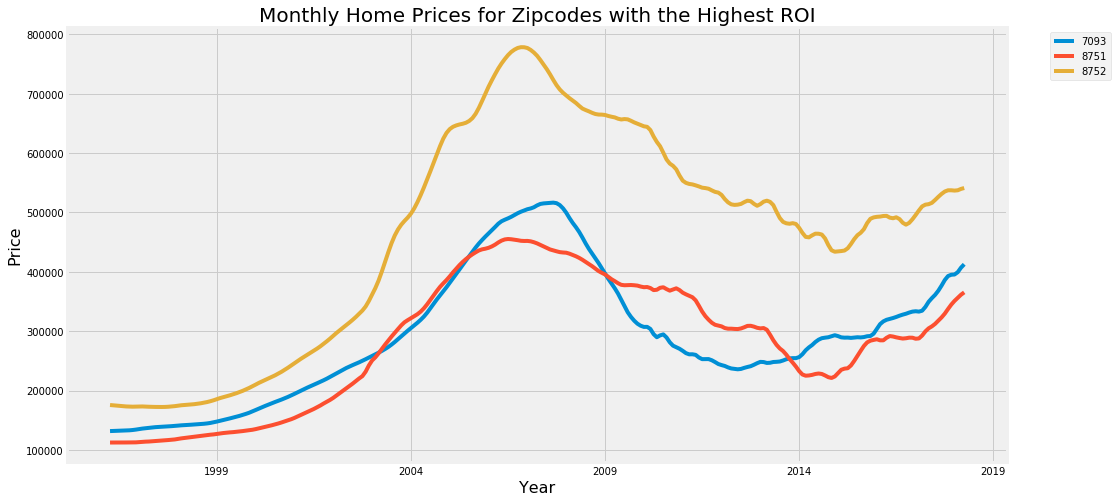

In [151]:
plt.figure(figsize=(14,6))
for zipcode in nj_ny_next.RegionName.unique():
    nj = nj_ny_next[nj_ny_next.RegionName == zipcode]
    nj['value'].plot(figsize=(15,8), label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel("Year", fontsize=16)
plt.ylabel("Price", fontsize=16)
plt.title("Monthly Home Prices for Zipcodes with the Highest ROI", fontsize=20);

In [152]:
test_period_next = 6
aic_params_next = []
for zipcode in nj_ny_next.RegionName.unique():
    ans = []
    for param in pdq:
        for param_seasonal in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(nj_ny_next.loc[nj_ny_next['RegionName'] == zipcode][:-test_period_next].value,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results_next = mod.fit()
                ans.append([zipcode, param, param_seasonal, results_next.aic])
            except:
                continue
    aic_params_next.append(sorted(ans, key=lambda x: x[3])[0])

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/lea

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/lea

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/lea

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/lea

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Volumes/Data/Users/jucabrera/anaconda3

In [153]:
aic_params_next

[[7093, (1, 1, 1), (1, 1, 1, 12), 4047.4609141358796],
 [8751, (1, 1, 1), (1, 1, 1, 12), 4046.2604526365412],
 [8752, (1, 1, 1), (1, 1, 1, 12), 4239.664946005797]]

In [154]:
models_next = []
for i in aic_params_next:
    df_ = nj_ny_next.loc[nj_ny_next['RegionName'] == i[0]][:-test_period_next].value.dropna()
    mod = sm.tsa.statespace.SARIMAX(df_,
                            order=i[1],
                            seasonal_order=i[2],
                            enforce_stationarity=False,
                            enforce_invertibility=False,)

    next_results = mod.fit()
    models_next.append(next_results)
    print(i[0], '\n' , next_results.summary().tables[1])

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


7093 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7967      0.039     20.248      0.000       0.720       0.874
ma.L1          0.7972      0.044     18.299      0.000       0.712       0.883
ar.S.L12       0.1489      0.042      3.511      0.000       0.066       0.232
ma.S.L12      -0.4780      0.033    -14.469      0.000      -0.543      -0.413
sigma2      2.405e+06   1.84e+05     13.094      0.000    2.04e+06    2.76e+06


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


8751 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7933      0.038     20.666      0.000       0.718       0.869
ma.L1          0.7894      0.033     23.585      0.000       0.724       0.855
ar.S.L12       0.1334      0.038      3.505      0.000       0.059       0.208
ma.S.L12      -0.5754      0.026    -22.311      0.000      -0.626      -0.525
sigma2       1.79e+06   1.22e+05     14.674      0.000    1.55e+06    2.03e+06


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


8752 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8731      0.034     25.546      0.000       0.806       0.940
ma.L1          0.3593      0.021     17.153      0.000       0.318       0.400
ar.S.L12      -0.5163      0.058     -8.953      0.000      -0.629      -0.403
ma.S.L12      -0.0378      0.032     -1.178      0.239      -0.101       0.025
sigma2      5.059e+06   1.07e-09   4.73e+15      0.000    5.06e+06    5.06e+06


In [155]:
predictions_next = []
for i in models_next:
    prediction_nj_next = i.forecast(steps=test_period_next)
    predictions_next.append(prediction_nj_next)

MAE: 9135.119418792261


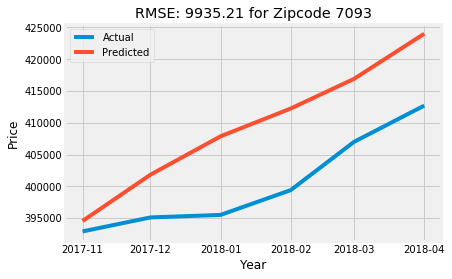

MAE: 6254.252682035498


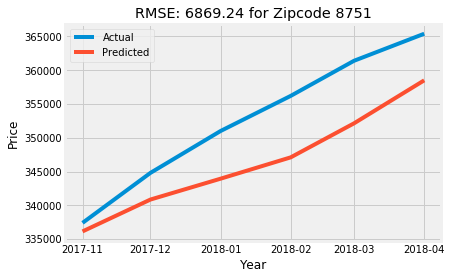

MAE: 7886.588487024729


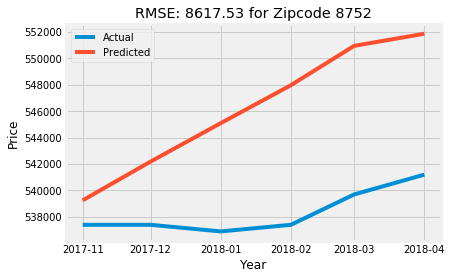

In [156]:
for i,j in zip(predictions_next,nj_ny_next.RegionName.unique()):
    plt.plot(nj_ny_next[nj_ny_next.RegionName==j].value[-test_period_next:])
    plt.plot(i)
    plt.xlabel("Year")
    plt.ylabel("Price")
    plt.title('RMSE: ' + str(round(np.sqrt(mean_squared_error(nj_ny_next[nj_ny_next.RegionName==j].value[-test_period_next:], i)),2)) + ' for Zipcode ' +  str(j)) 
    plt.legend(['Actual', 'Predicted'])
    print('MAE:', mean_absolute_error(nj_ny_next[nj_ny_next.RegionName==j].value[-test_period_next:], i))
    plt.show()

In [157]:
final_models_next = []
for i in aic_params_next:
    df_ = nj_ny_next.loc[nj_ny_next['RegionName'] == i[0]].value.dropna()
    mod = sm.tsa.statespace.SARIMAX(df_,
                            order=i[1],
                            seasonal_order=i[2],
                            enforce_stationarity=False,
                            enforce_invertibility=False,)

    next_results_final = mod.fit()
    final_models_next.append(next_results_final)
    print(i[0], '\n' , next_results_final.summary().tables[1])

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


7093 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7746      0.040     19.556      0.000       0.697       0.852
ma.L1          0.8068      0.043     18.835      0.000       0.723       0.891
ar.S.L12       0.1493      0.041      3.676      0.000       0.070       0.229
ma.S.L12      -0.4763      0.032    -15.066      0.000      -0.538      -0.414
sigma2      2.503e+06   1.94e+05     12.912      0.000    2.12e+06    2.88e+06


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


8751 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7805      0.057     13.763      0.000       0.669       0.892
ma.L1          0.7961      0.049     16.218      0.000       0.700       0.892
ar.S.L12       0.1623      0.050      3.216      0.001       0.063       0.261
ma.S.L12      -0.5189      0.037    -14.121      0.000      -0.591      -0.447
sigma2      2.875e+06    2.8e+05     10.265      0.000    2.33e+06    3.42e+06


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


8752 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8743      0.034     25.611      0.000       0.807       0.941
ma.L1          0.3556      0.020     17.655      0.000       0.316       0.395
ar.S.L12      -0.5328      0.057     -9.402      0.000      -0.644      -0.422
ma.S.L12      -0.0367      0.031     -1.174      0.240      -0.098       0.025
sigma2      5.064e+06   8.33e-10   6.08e+15      0.000    5.06e+06    5.06e+06


7093


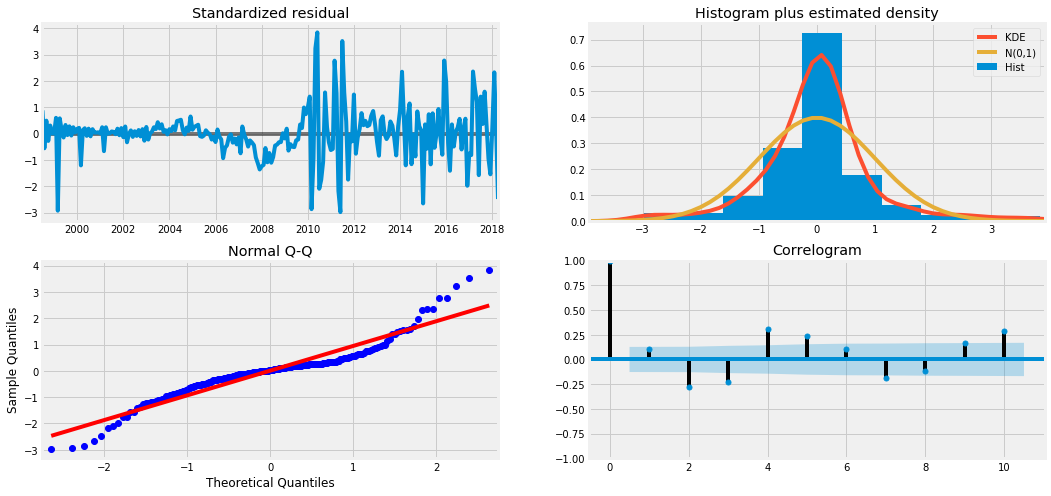

8751


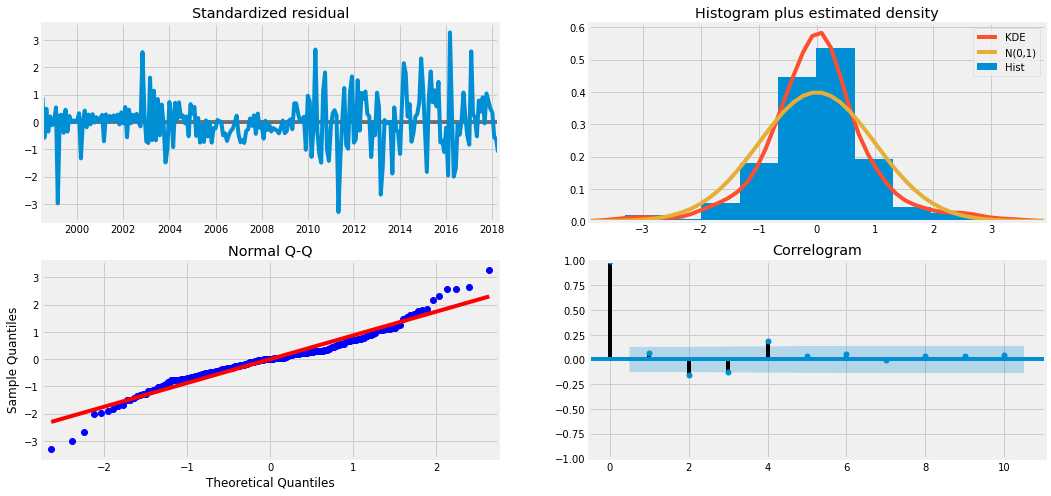

8752


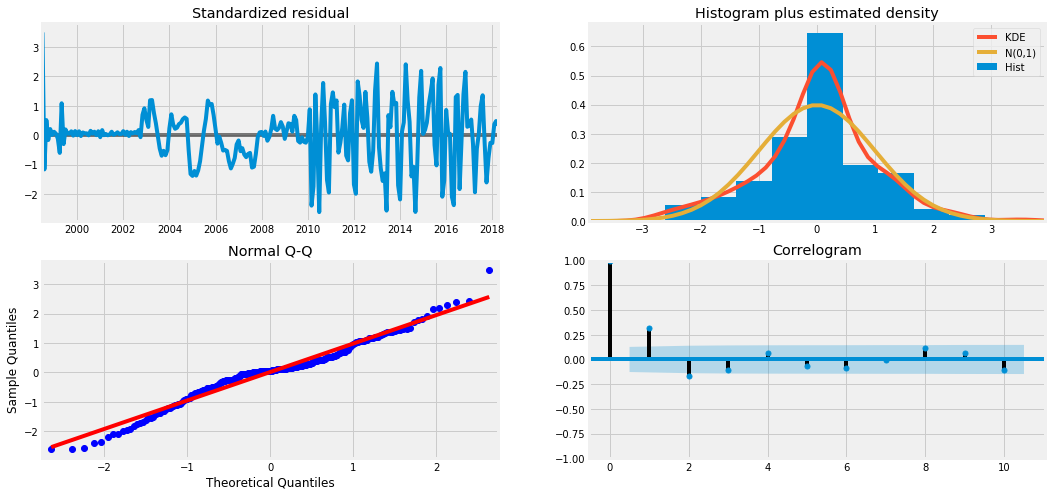

In [158]:
for i, zipcode in zip(final_models_next, aic_params_next):
    print(zipcode[0])
    i.plot_diagnostics(figsize=(16,8))
    plt.show()

In [159]:
forecast_6mon_next = []
intervals_6mon_next = []
for i in final_models_next:
    prediction_nj_ny6_next = i.get_forecast(steps=6)
    pred_conf_nj_ny6_next = prediction_nj_ny6_next.conf_int()
    forecast_6mon_next.append(prediction_nj_ny6_next)
    intervals_6mon_next.append(pred_conf_nj_ny6_next)

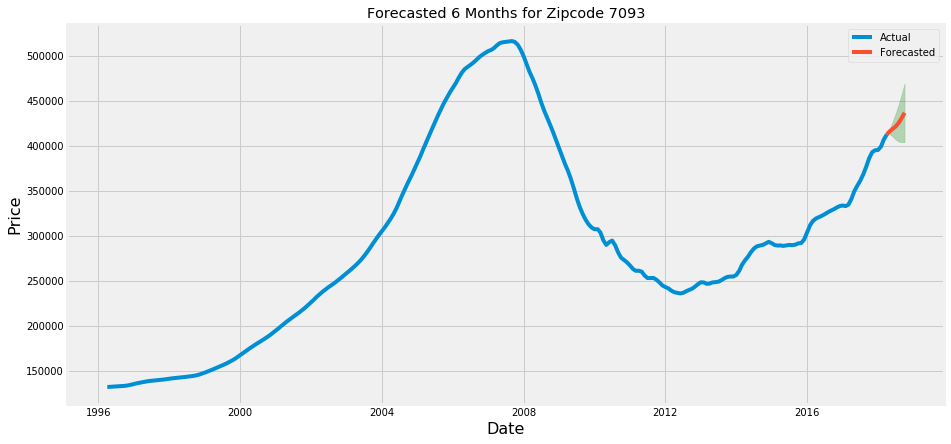

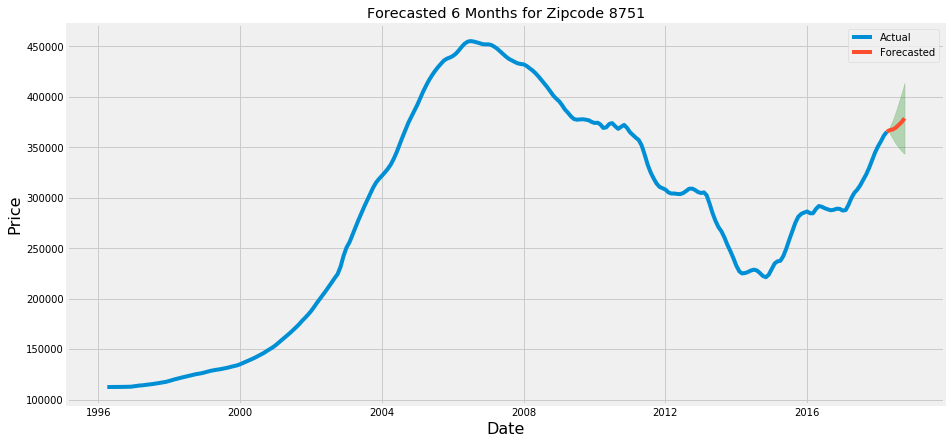

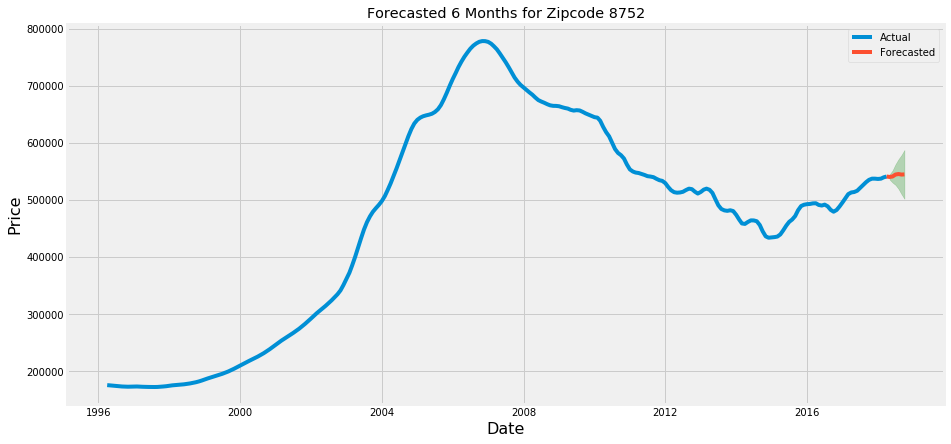

In [160]:
for i,j,k in zip(forecast_6mon_next,intervals_6mon_next,nj_ny_next.RegionName.unique()):
    plt.figure(figsize=(14,7))
    forecast_ = list(i.predicted_mean.values) # a list of the forecasted values
    index_ = list(forecast_6mon_next[0].predicted_mean.index) # a list of the index of the forecasted values
    forecast_.insert(0, list(nj_ny_next[nj_ny_next.RegionName==k].value)[-1]) # adding the last value of the true data
    index_.insert(0, list(nj_ny_next[nj_ny_next.RegionName==k].index)[-1]) # adding the last index of the true data
    plt.plot(nj_ny_next[nj_ny_next.RegionName==k].value)
    plt.plot(index_, forecast_)
    plt.fill_between(j.index,
                   j.iloc[:, 0],
                   j.iloc[:, 1], color = 'g', alpha=.25)
    plt.legend(['Actual', 'Forecasted'])
    plt.xlabel("Year", fontsize=16)
    plt.ylabel("Price", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title('Forecasted 6 Months for Zipcode ' + str(k))
    plt.show()


In [161]:
forecast_1y_next = []
intervals_1y_next = []
for i in final_models_next:
    prediction_nj_ny1_next = i.get_forecast(steps=12)
    pred_conf_nj_ny1_next = prediction_nj_ny1_next.conf_int()
    forecast_1y_next.append(prediction_nj_ny1_next)
    intervals_1y_next.append(pred_conf_nj_ny1_next)

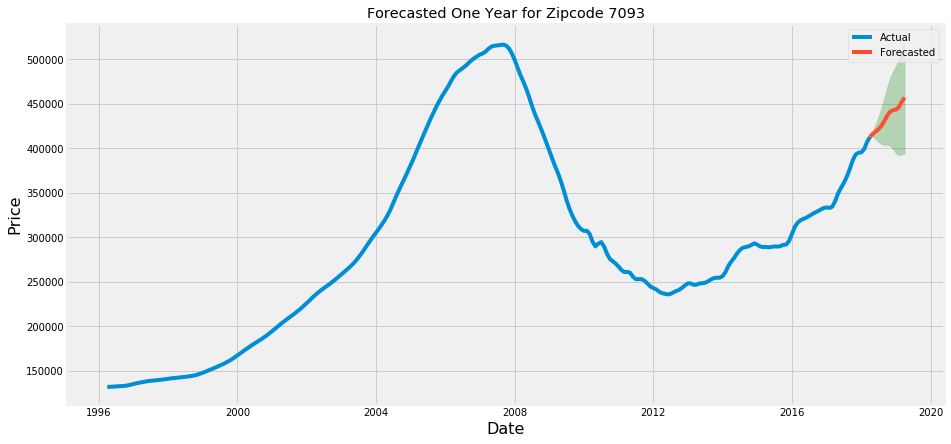

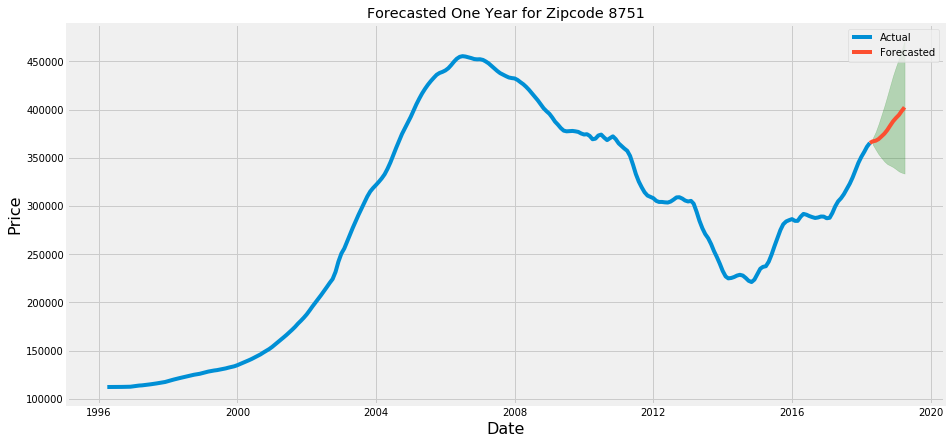

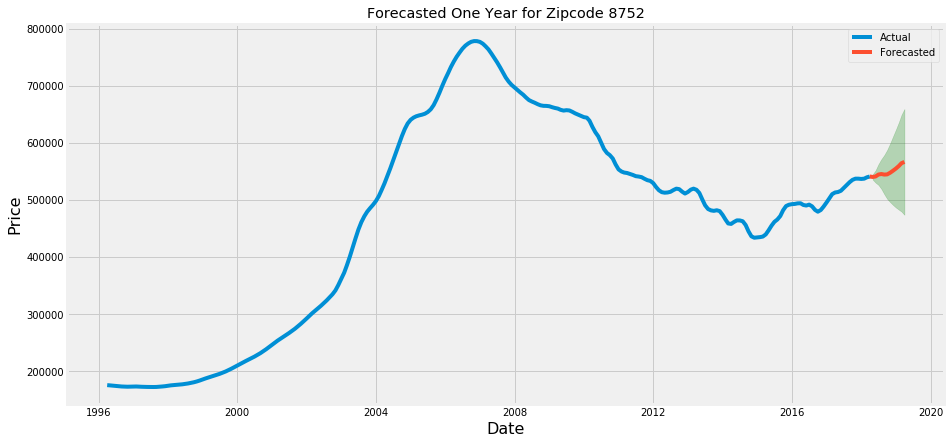

In [162]:
for i,j,k in zip(forecast_1y_next,intervals_1y_next,nj_ny_next.RegionName.unique()):
    plt.figure(figsize=(14,7))
    forecast_ = list(i.predicted_mean.values) # a list of the forecasted values
    index_ = list(forecast_1y_next[0].predicted_mean.index) # a list of the index of the forecasted values
    forecast_.insert(0, list(nj_ny_next[nj_ny_next.RegionName==k].value)[-1]) # adding the last value of the true data
    index_.insert(0, list(nj_ny_next[nj_ny_next.RegionName==k].index)[-1]) # adding the last index of the true data
    plt.plot(nj_ny_next[nj_ny_next.RegionName==k].value)
    plt.plot(index_, forecast_)
    plt.fill_between(j.index,
                   j.iloc[:, 0],
                   j.iloc[:, 1], color = 'g', alpha=.25)
    plt.legend(['Actual', 'Forecasted'])
    plt.xlabel("Year", fontsize=16)
    plt.ylabel("Price", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title('Forecasted One Year for Zipcode ' + str(k))
    plt.show()

In [163]:
forecast_5y_next = []
intervals_5y_next = []
for i in final_models_next:
    prediction_nj_ny5_next = i.get_forecast(steps=60)
    pred_conf_nj_ny5_next = prediction_nj_ny5_next.conf_int()
    forecast_5y_next.append(prediction_nj_ny5_next)
    intervals_5y_next.append(pred_conf_nj_ny5_next)

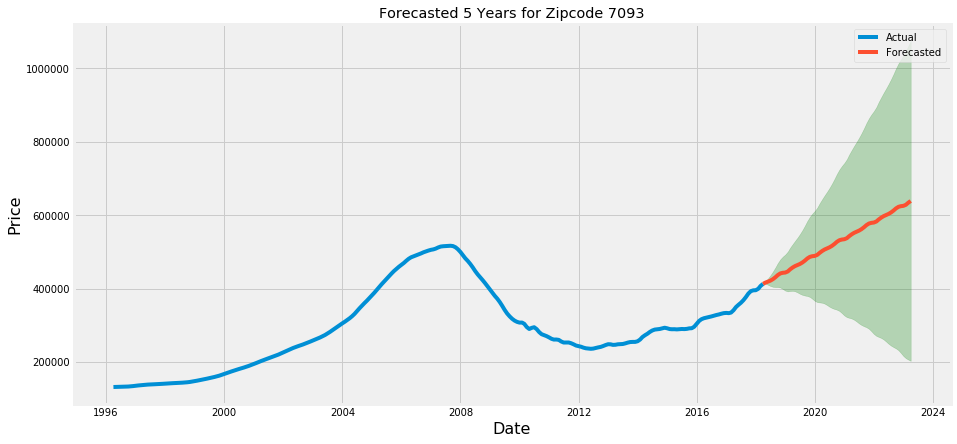

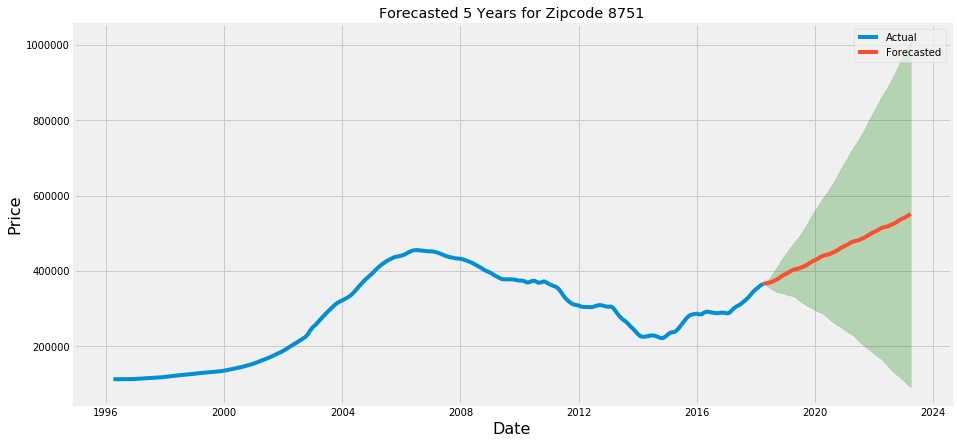

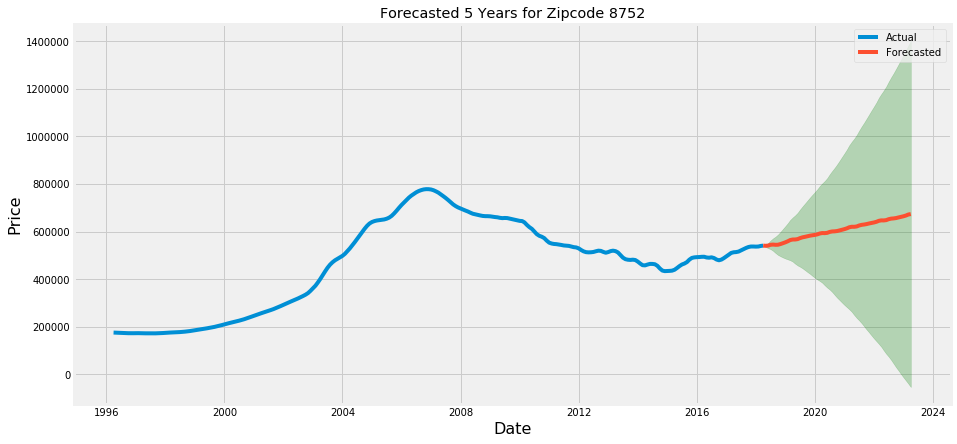

In [164]:
for i,j,k in zip(forecast_5y_next,intervals_5y_next,nj_ny_next.RegionName.unique()):
    plt.figure(figsize=(14,7))
    forecast_ = list(i.predicted_mean.values) # a list of the forecasted values
    index_ = list(forecast_5y_next[0].predicted_mean.index) # a list of the index of the forecasted values
    forecast_.insert(0, list(nj_ny_next[nj_ny_next.RegionName==k].value)[-1]) # adding the last value of the true data
    index_.insert(0, list(nj_ny_next[nj_ny_next.RegionName==k].index)[-1]) # adding the last index of the true data
    plt.plot(nj_ny_next[nj_ny_next.RegionName==k].value)
    plt.plot(index_, forecast_)
    plt.fill_between(j.index,
                   j.iloc[:, 0],
                   j.iloc[:, 1], color = 'g', alpha=.25)
    plt.legend(['Actual', 'Forecasted'])
    plt.xlabel("Year", fontsize=16)
    plt.ylabel("Price", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title('Forecasted 5 Years for Zipcode ' + str(k))
    plt.show()

In [165]:
forecast_10y_next = []
intervals_10y_next = []
for i in final_models_next:
    prediction_nj_ny10_next = i.get_forecast(steps=120)
    pred_conf_nj_ny10_next = prediction_nj_ny10_next.conf_int()
    forecast_10y_next.append(prediction_nj_ny10_next)
    intervals_10y_next.append(pred_conf_nj_ny10_next)

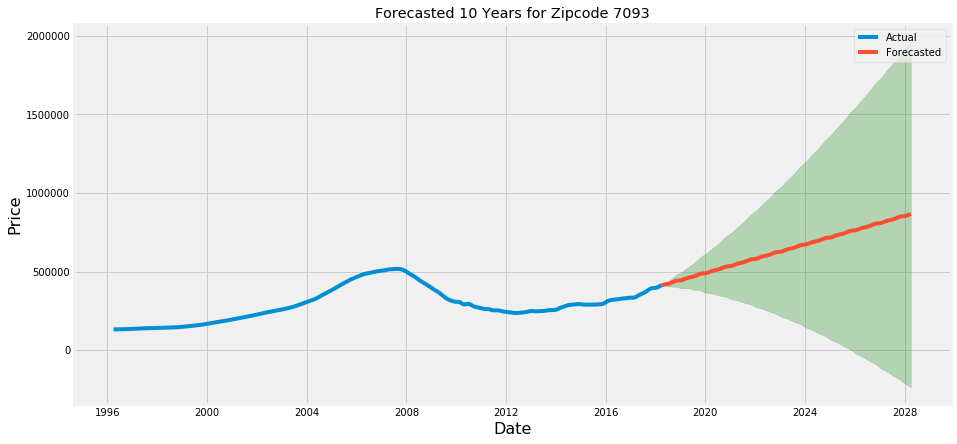

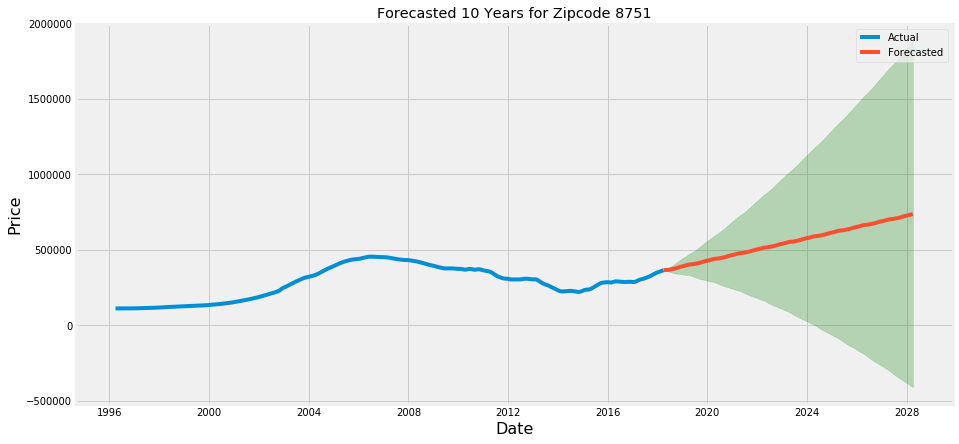

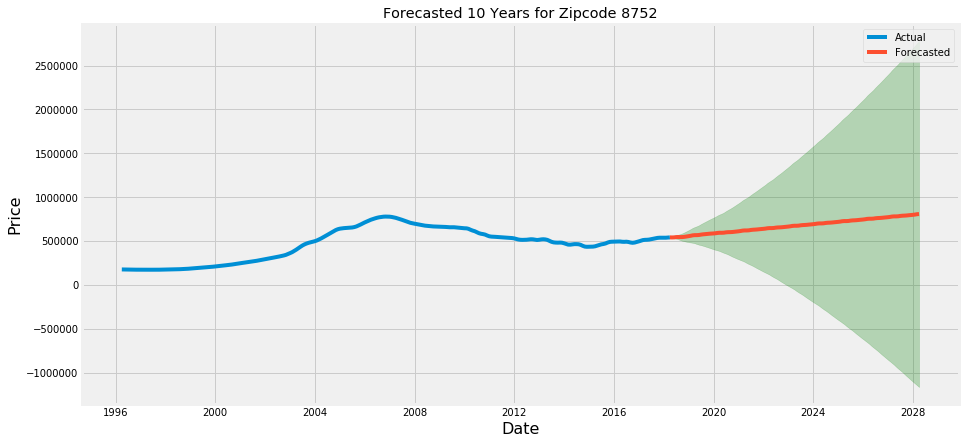

In [166]:
for i,j,k in zip(forecast_10y_next,intervals_10y_next,nj_ny_next.RegionName.unique()):
    plt.figure(figsize=(14,7))
    forecast_ = list(i.predicted_mean.values) # a list of the forecasted values
    index_ = list(forecast_10y_next[0].predicted_mean.index) # a list of the index of the forecasted values
    forecast_.insert(0, list(nj_ny_next[nj_ny_next.RegionName==k].value)[-1]) # adding the last value of the true data
    index_.insert(0, list(nj_ny_next[nj_ny_next.RegionName==k].index)[-1]) # adding the last index of the true data
    plt.plot(nj_ny_next[nj_ny_next.RegionName==k].value)
    plt.plot(index_, forecast_)
    plt.fill_between(j.index,
                   j.iloc[:, 0],
                   j.iloc[:, 1], color = 'g', alpha=.25)
    plt.legend(['Actual', 'Forecasted'])
    plt.xlabel("Year", fontsize=16)
    plt.ylabel("Price", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title('Forecasted 10 Years for Zipcode ' + str(k))
    plt.show()

In [167]:
forecasted_values_6mons_next = []
forecasted_values_1yr_next = []
forecasted_values_5yrs_next = []
forecasted_values_10yrs_next = []
for i,j,k,l in zip(forecast_6mon_next, forecast_1y_next, forecast_5y_next, forecast_10y_next):
    values6_next = i.predicted_mean
    values1_next = j.predicted_mean
    values5_next = k.predicted_mean
    values10_next = l.predicted_mean
    forecasted_values_6mons_next.append(values6_next)
    forecasted_values_1yr_next.append(values1_next)
    forecasted_values_5yrs_next.append(values5_next)
    forecasted_values_10yrs_next.append(values10_next)

In [168]:
six_07093 = pd.DataFrame(forecasted_values_6mons_next[0], columns=['6mon'])
six_08751 = pd.DataFrame(forecasted_values_6mons_next[1], columns=['6mon'])
six_08752 = pd.DataFrame(forecasted_values_6mons_next[2], columns=['6mon'])

six_months_next = pd.concat([six_07093, six_08751, six_08752], axis=1)
six_months_next.columns = ['07093', '08751', '08752']

print('07093:', roi(six_months_next['07093'][-1], nj_ny_next[nj_ny_next['RegionName']==7093].value[-1]))
print('08751:', roi(six_months_next['08751'][-1], nj_ny_next[nj_ny_next['RegionName']==8751].value[-1]))
print('08752:', roi(six_months_next['08752'][-1], nj_ny_next[nj_ny_next['RegionName']==8752].value[-1]))

07093: 5.85
08751: 3.65
08752: 0.68


In [169]:
one_07093 = pd.DataFrame(forecasted_values_1yr_next[0], columns=['1year'])
one_08751 = pd.DataFrame(forecasted_values_1yr_next[1], columns=['1year'])
one_08752 = pd.DataFrame(forecasted_values_1yr_next[2], columns=['1year'])

one_year_next = pd.concat([one_07093, one_08751, one_08752], axis=1)
one_year_next.columns = ['07093', '08751', '08752']

print('07093:', roi(one_year_next['07093'][-1], nj_ny_next[nj_ny_next['RegionName']==7093].value[-1]))
print('08751:', roi(one_year_next['08751'][-1], nj_ny_next[nj_ny_next['RegionName']==8751].value[-1]))
print('08752:', roi(one_year_next['08752'][-1], nj_ny_next[nj_ny_next['RegionName']==8752].value[-1]))

07093: 10.78
08751: 10.09
08752: 4.73


In [170]:
five_07093 = pd.DataFrame(forecasted_values_5yrs_next[0], columns=['5years'])
five_08751 = pd.DataFrame(forecasted_values_5yrs_next[1], columns=['5years'])
five_08752 = pd.DataFrame(forecasted_values_5yrs_next[2], columns=['5years'])

five_year_next = pd.concat([five_07093, five_08751, five_08752], axis=1)
five_year_next.columns = ['07093', '08751', '08752']

print('07093:', roi(five_year_next['07093'][-1], nj_ny_next[nj_ny_next['RegionName']==7093].value[-1]))
print('08751:', roi(five_year_next['08751'][-1], nj_ny_next[nj_ny_next['RegionName']==8751].value[-1]))
print('08752:', roi(five_year_next['08752'][-1], nj_ny_next[nj_ny_next['RegionName']==8752].value[-1]))

07093: 54.75
08751: 50.79
08752: 24.52


In [171]:
ten_07093 = pd.DataFrame(forecasted_values_10yrs_next[0], columns=['5years'])
ten_08751 = pd.DataFrame(forecasted_values_10yrs_next[1], columns=['5years'])
ten_08752 = pd.DataFrame(forecasted_values_10yrs_next[2], columns=['5years'])

ten_year_next = pd.concat([ten_07093, ten_08751, ten_08752], axis=1)
ten_year_next.columns = ['07093', '08751', '08752']

print('07093:', roi(ten_year_next['07093'][-1], nj_ny_next[nj_ny_next['RegionName']==7093].value[-1]))
print('08751:', roi(ten_year_next['08751'][-1], nj_ny_next[nj_ny_next['RegionName']==8751].value[-1]))
print('08752:', roi(ten_year_next['08752'][-1], nj_ny_next[nj_ny_next['RegionName']==8752].value[-1]))

07093: 109.86
08751: 101.79
08752: 49.19


In [172]:
forecast_data_next = {'Zipcode':['07093', '08751', '08752'], 
                 '6 Months ROI %':[5.85, 3.65, 0.68],
                '1 Year ROI %':[10.78, 10.09, 4.73],
                '5 Year ROI %':[54.75, 50.79, 25.52],
                '10 Year ROI %':[109.86, 101.79, 49.19]}
forecast_df_next = pd.DataFrame(forecast_data_next)
forecast_df_next

,Zipcode,6 Months ROI %,1 Year ROI %,5 Year ROI %,10 Year ROI %
0,07093,5.85,10.78,54.75,109.86
1,08751,3.65,10.09,50.79,101.79
2,08752,0.68,4.73,25.52,49.19


In [173]:
top_5_forecast = pd.concat([forecast_df, forecast_df_next])

In [174]:
top_5_forecast.reset_index(inplace=True)

In [175]:
top_5_forecast.drop(labels=[3,4,7], axis=0, inplace=True)

In [176]:
top_5_forecast.drop(labels='index', axis=1, inplace=True)

In [177]:
top_5_forecast.sort_values(by='10 Year ROI %', ascending=False)

,Zipcode,6 Months ROI %,1 Year ROI %,5 Year ROI %,10 Year ROI %
2,07307,11.07,20.89,122.25,248.66
1,07306,7.71,17.61,86.85,173.35
0,07087,9.67,18.94,86.93,171.13
5,07093,5.85,10.78,54.75,109.86
6,08751,3.65,10.09,50.79,101.79
